# Подгружаем все что может понадобится

In [3]:
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import warnings
import math
from copy import deepcopy
from tqdm.notebook import tqdm
import matplotlib as mpl
import platform
from collections import Counter
from IPython.core.display import HTML
import os
from copy import deepcopy
import json
from statistics import median
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10000




# Посмотрим на наши данные и почистим их

In [4]:
#fol = pd.read_csv("/Users/a185583357/Downloads/MMzip/fol/LKOH.txt", sep=",")

#TODO Inspect 20150923 - lots of errors there
fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog20150310/OrderLog20150310.txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
fol.tail()

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
26214948,26214949,FXIT,S,184457675,12836191,0,2461.0000,11285,nan,NaN
26214949,26214950,OGKB,S,184458220,12805810,0,0.2164,1000,nan,NaN
26214950,26214951,SBER,B,184458269,12819204,0,69.0900,30,nan,NaN
26214951,26214952,VZRZP,S,184458683,6479754,0,91.5000,20,nan,NaN
26214952,26214953,FXGD,S,184459634,12836206,0,519.0000,56500,nan,NaN


In [5]:


count = Counter(fol["SECCODE"]).most_common(30)
out = []
for share in count:
    out.append(share[0])
count

[('GAZP', 2997383),
 ('SBER', 2290044),
 ('SNGS', 2087074),
 ('CHMF', 1425078),
 ('RTKM', 1339749),
 ('LKOH', 1049386),
 ('ROSN', 844480),
 ('SBERP', 738394),
 ('VTBR', 714055),
 ('HYDR', 713783),
 ('SNGSP', 712352),
 ('MGNT', 704247),
 ('TRNFP', 694222),
 ('GMKN', 631399),
 ('NLMK', 593623),
 ('MTSS', 593605),
 ('MTLR', 581235),
 ('MOEX', 551809),
 ('URKA', 468585),
 ('TATN', 459544),
 ('ALRS', 456695),
 ('MAGN', 436832),
 ('EONR', 418226),
 ('FEES', 377768),
 ('AFKS', 366013),
 ('IRAO', 330446),
 ('MVID', 258997),
 ('NVTK', 251434),
 ('OGKB', 191821),
 ('SIBN', 191810)]

In [6]:
fol.head(5)

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1,ENRU,B,100000000,1,1,0.785,100000,nan,NaN
1,2,SBERP,B,100000000,2,1,52.400,10000,nan,NaN
2,3,AFKS,B,100000000,3,1,15.880,100,nan,NaN
3,4,AFLT,B,100000000,4,1,37.000,100,nan,NaN
4,5,ALRS,S,100000000,5,1,77.000,20000,nan,NaN


#  Соберем стакан из этого

Общая идея взята из статьи - https://habr.com/ru/post/276635/

In [7]:
from sortedcontainers import SortedDict

class DOM:
    def __init__(self):
        self.bid = SortedDict() #descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.day = None
        self.flag = None
        
    
    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.day = data["DATE"]
        
        if data["ACTION"] == 1:
            self.check_add(data)
        elif data["ACTION"] == 0:
            self.delete_order(data)
        else:
            self.trade(data)
        
    ## First part - adding order
        
    def check_add(self, data):
        if data["PRICE"] < 0.000000001:
            self.add_order(data)
            pass
        else:
            self.add_order(data)
                
    
    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
    ## Second part - delete order
    
    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]
    
    ## Third part - match order   
    def trade(self, data):
        if data['BUYSELL'] == "B":
            self.exec_buy_order(data)
        else:
            self.exec_sell_order(data)
    

    def exec_sell_order(self, data):
        self.flag = None
        order = self.ask_active_order[data["ORDERNO"]]
        if data["VOLUME"] < order[1]:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], 
                                                      order[1] - data["VOLUME"])
        elif data["VOLUME"] == order[1]:
            del self.ask_active_order[data["ORDERNO"]]
        else:
            #iseberg or error
            #raise Exception(self.ask_active_order[data["ORDERNO"]], data)
            del self.ask_active_order[data["ORDERNO"]]
            self.flag = data["ORDERNO"]
            
        
        if data["PRICE"] not in self.ask:
            raise Exception
            pass
        else:
            self.ask[data["PRICE"]] -= min(order[1], data["VOLUME"])
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    
    
    def exec_buy_order(self, data):
        self.flag = None
        order = self.bid_active_order[data["ORDERNO"]]
        if data["VOLUME"] < order[1]:
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], 
                                                      order[1] - data["VOLUME"])
        elif data["VOLUME"] == order[1]:
            del self.bid_active_order[data["ORDERNO"]]
        else:
            #iseberg or error
            #raise Exception(self.bid_active_order[data["ORDERNO"]], data)
            del self.bid_active_order[data["ORDERNO"]]
            flag = data["ORDERNO"]
        
        if data["PRICE"] not in self.bid:
            raise Exception(data, self.bid)
            pass
        else:
            self.bid[data["PRICE"]] -= min(order[1], data["VOLUME"])
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
    
    ## Others
    
        
    def clean_dom(self):
        self.__init__()
        
        

In [8]:
date = "20150527"
data = fol[fol["SECCODE"] == "LKOH"]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(989860, 12)

In [9]:
dom = DOM()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

# Для корректной работы бектеста и чтобы стакан сходился необходимо научится вычислять айсберги

### Делать это будем следующим образом - сверять у каждой заявки объем поторгованного и выставленного - и если объем поторгованного больше, то это точно айсберг и заменяем ему объем на сумму всего поторгованного.

In [6]:

def get_isebergs(dt):
    isebergs = dict()

    all_orders = sorted(list(set(dt["ORDERNO"])))
    for i in tqdm(range(len(all_orders))):
        out = dt[dt["ORDERNO"] == all_orders[i]]
        if 2 not in set(out["ACTION"]):
            continue
        else:
            trades = out[out["ACTION"] == 2]
            sum_of_trades = sum(trades["VOLUME"])
            visible = sum(out[out["ACTION"] == 1][:1]["VOLUME"])
            if visible < sum_of_trades:
                isebergs[all_orders[i]] = sum_of_trades
    return isebergs
        
#isebergs = get_isebergs(fol)

Надо сохранить эти айсберги для каждого дня а то они очень долго считаются

In [4]:
#pd.DataFrame(isebergs, index=["vol"]).T.to_csv("test.csv")
#pd.read_csv("test.csv",index_col=0).to_dict()["vol"]

In [38]:
import datetime


def get_one_iseberg(args):
    lkoh, date, sec = args[0], args[1], args[2]
    try:
        pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + sec + date + ".csv")
    except KeyboardInterrupt:
        raise Exception
    except:
        isebergs = get_isebergs(lkoh)
        print("Num of isebergs for", sec, "at", date, "is", len(isebergs))
        df = pd.DataFrame(isebergs, index=["vol"]).T
        df.to_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + sec + date + ".csv")


def get_all_isebergs(date, sec):
    args_lst = []
    while date != "20160301":
        date_fst = datetime.datetime.strptime(date, "%Y%m%d")
        date = (date_fst + datetime.timedelta(days=1)).strftime("%Y%m%d")
        try:
            super_fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/OrderLog" + date + ".txt", sep=",")
        except KeyboardInterrupt:
            break
        except:
            continue
        lkoh = super_fol[super_fol["SECCODE"] == sec]
        del super_fol
        get_one_iseberg([lkoh, date, sec])
        print(date)
        

In [ ]:
date = "20150923"
sec = "LKOH"
#get_all_isebergs(date, sec)


Готовы данные по всем айсбергам за год

# Сделаем заготовку под тестирование года и заодно проверим валидность данных

In [ ]:
dom = Matching_Engine()

In [ ]:
import datetime

date_fst = datetime.datetime.strptime("20150302", "%Y%m%d")
(date_fst + datetime.timedelta(days=1)).strftime("%Y%m%d")

### Код ниже в этом блоке надо запускать в конце, после Matching Engine и нужного алго

In [39]:
import datetime
import time
import multiprocessing
from joblib import Parallel, delayed
from copy import deepcopy

num_cores = multiprocessing.cpu_count()


def backtest_day(all_params, share, show_stat):
    date, fol, dom, start_time, algo = all_params[0], all_params[1], all_params[2], all_params[3], all_params[4]

    if share == "LKOH":
        if platform.system() == "Darwin":
            isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv",
                                   index_col=0).to_dict()["vol"]
        else:
            isebergs = pd.read_csv("D:\\OrderLog" + date + "\\isebergs" + date + ".csv",
                                   index_col=0).to_dict()["vol"]
    else:
        if platform.system() == "Darwin":
            isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + share + date + ".csv",
                                   index_col=0).to_dict()["vol"]
        else:
            isebergs = pd.read_csv("D:\\OrderLog" + date + "\\isebergs_" + share + date + ".csv",
                        index_col=0).to_dict()["vol"]
    fol = fol[fol["ACTION"] != 2]
    fol["DATE"] = date
    records = fol.to_dict("records")
    algo.first_price = max(records[1000]["PRICE"], records[1001]["PRICE"], records[1002]["PRICE"])
    errors = 0
    algo_errors = 0
    algo_orders = None

    # print("Num of icebergs - ", len(isebergs), "\nStart of market simulation")
    for i in tqdm(range(len(records))):
        record = records[i].copy()
        if algo_orders and int(record["TIME"]) > algo_orders[-1]["TIME"] + latency:
            out_algo = []
            for order in algo_orders:
                order["DATE"] = date
            
                try:
                    out = dom.check_order(order)
                    if out:
                        out_algo.extend(out)
                except KeyboardInterrupt:
                    break
                except Exception as e:
                    if order["ACTION"] == 1:
                        print(dom.trade_log)
                        print(dom.bid)
                        print(dom.bid_FIFO)
                        print(order)
                        dom.check_order(order)
                        print("MAYBE Some problem, cant add order. Exc - ", e, sys.exc_info())
                    algo_errors += 1
            algo_orders = None
            if len(out_algo) > 0:
                algo.change_cash_share(out_algo)

        if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
            record["VOLUME"] = isebergs[record["ORDERNO"]]
        try:
            out = dom.check_order(record)
            algo.change_cash_share(out)
        except KeyboardInterrupt:
            break
        except:
            errors += 1
        if not algo_orders:
            algo_orders = algo.trading(dom, time=record["TIME"],
                                       first_sma=max(records[1000]["PRICE"], records[1001]["PRICE"]))
    print("Num of historic reject - ", errors, ", algo reject - ", algo_errors)
    print("Share -", share, datetime.datetime.now())
    print("--- %s overall seconds ---" % (time.time() - start_time))

    trade_log = pd.DataFrame((dom.trade_log),
                             columns=["PRICE", 'VOLUME', 'NEW-ORDER-ID', 'PAST-ORDER-ID', "TURNOVER", "TIME", 'NO',
                                      'BUYSELL'])

    algo_raw = pd.concat([trade_log[trade_log["NEW-ORDER-ID"].apply(isinstance, args=(str,))],
                          trade_log[trade_log["PAST-ORDER-ID"].apply(isinstance, args=(str,))]])
    if show_stat:
        #try:
            algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, share=share,
                       bid_ask=True, show_deals=True)
        #except Exception as e:
         #   print("\n\n\nSome problems with algo stats\n Exception - ", e, "\n\n\n")
    else:
        print(date)
    return day_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, dom, share=share)


def backtest_year(date, dom, algo, share="LKOH", enddate="20160301", show_stat=False):
    out = SortedDict()
    arg_list = []
    stat_list = []
    while date != enddate:
        #print(date)
        start_time = time.time()
        date_fst = datetime.datetime.strptime(date, "%Y%m%d")
        date = (date_fst + datetime.timedelta(days=1)).strftime("%Y%m%d")
        try:
            super_fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/OrderLog" + date + ".txt", sep=",")
            #print("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/OrderLog" + date + ".txt")
        except KeyboardInterrupt:
            break
        except:
            continue
        lkoh = super_fol[super_fol["SECCODE"] == share]
        del super_fol
        stats = backtest_day([date, lkoh, dom, start_time, deepcopy(algo)], share, show_stat)
        stat_list.append(stats)
    return stat_list



ModuleNotFoundError: No module named 'joblib'

In [92]:
outp = backtest_year('20150301', Matching_Engine(), Basic_MM(spread=0.003, sma_len=5, cash=2000000, ), enddate="20150902", share="LKOH", show_stat=True)
outp


Num of historic reject -  4363 , algo reject -  4
Share - ROSN 2020-12-07 16:35:07.372252
--- 37.019169092178345 overall seconds ---


NameError: name 'algo_stats' is not defined

In [72]:
order

{'BUYSELL': 'S',
 'ACTION': 1,
 'PRICE': 0.088615,
 'TIME': 100000000,
 'VOLUME': 1320000,
 'ORDERNO': 'myorder0',
 'NO': 'mm',
 'DATE': '20150527'}

In [ ]:
graph = []

for i in range(len(out)):
   #print(i)
    try:
        graph.append((out.peekitem(i)[1][1]).peekitem(0)[0])
    except:
        try:
            graph.append((out.peekitem(i)[1][0]).peekitem(-1)[0])
        except:
            continue

In [ ]:
plt.plot(graph)

# Создадим стакан способный сам матчить все заявки и сравним с оригиналом

In [10]:
date = "20150527"
data = fol[fol["SECCODE"] == "SBER"]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(2115840, 12)

In [11]:
data.head()

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,47,48,SBER,B,100000000,48,1,70.00,20,nan,NaN,20150527
1,49,50,SBER,B,100000000,50,1,70.50,880,nan,NaN,20150527
2,94,95,SBER,B,100000000,95,1,72.45,15000,nan,NaN,20150527
3,138,139,SBER,B,100000000,139,1,72.23,10700,nan,NaN,20150527
4,147,148,SBER,B,100000000,148,1,71.00,100,nan,NaN,20150527


In [12]:
class Matching_Engine:
    def __init__(self):
        self.bid = SortedDict()  # descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.bid_FIFO = dict()
        self.ask_FIFO = dict()
        self.day = None
        self.share_name = "LKOH"
        self.trade_log = []

    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.share_name = data["SECCODE"]
            self.day = data["DATE"]

        if data["ACTION"] == 1:
            return self.check_add(data, new_trades=[])
        elif data["ACTION"] == 2:
            pass
        else:
            self.delete_order(data)

    ## First part - adding order

    def check_add(self, data, rec_flag=False, new_trades=[]):
        if (len(self.ask) > 0 and data['BUYSELL'] == "B" and \
            (data["PRICE"] >= self.ask.peekitem(0)[0] or data["PRICE"] < 0.000001)) or \
                (len(self.bid) > 0 and data['BUYSELL'] == "S" and data["PRICE"] <= self.bid.peekitem(-1)[0]):
            if not rec_flag:
                self.add_order(data)
            return self.trade(data, new_trades=new_trades)
        else:
            if not rec_flag:
                self.add_order(data)

    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
                self.bid_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
                self.bid_FIFO[data["PRICE"]].append(data["ORDERNO"])
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
                self.ask_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
                self.ask_FIFO[data["PRICE"]].append(data["ORDERNO"])

    ## Second part - delete order

    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_FIFO[data["PRICE"]].pop(self.bid_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            if len(self.bid_FIFO[data["PRICE"]]) < 1:
                del self.bid_FIFO[data["PRICE"]]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            self.ask_FIFO[data["PRICE"]].pop(self.ask_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            if len(self.ask_FIFO[data["PRICE"]]) < 1:
                del self.ask_FIFO[data["PRICE"]]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    ## Third part - match order
    def trade(self, data, new_trades=[]):
        if data['BUYSELL'] == "B":
            return self.exec_buy_order(data, new_trades=new_trades)
        else:
            return self.exec_sell_order(data, new_trades=new_trades)

    def exec_sell_order(self, data, new_trades=[]):
        go_trade= True
        while go_trade:
            go_trade = False
            sell_order = self.ask_active_order[data["ORDERNO"]]
            tradeprice = self.bid.peekitem(-1)[0]
            order_no = self.bid_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            buy_order = self.bid_active_order[order_no]
            if buy_order[1] > sell_order[1]:
                self.bid_active_order[order_no] = (self.bid_active_order[order_no][0],
                                                   buy_order[1] - sell_order[1])
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "B"

                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no

                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "B"
                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0],
                                                          sell_order[1] - buy_order[1])
                # TODO не учтено полное пробитие стакана!!
                if self.bid.peekitem(-1)[0] >= sell_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "S"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.ask[data["PRICE"]] -= data["VOLUME"]
                #return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    def exec_buy_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            buy_order = self.bid_active_order[data["ORDERNO"]]
            tradeprice = self.ask.peekitem(0)[0]
            order_no = self.ask_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            sell_order = self.ask_active_order[order_no]
            if sell_order[1] > buy_order[1]:
                self.ask_active_order[order_no] = (self.ask_active_order[order_no][0],
                                                   sell_order[1] - buy_order[1])
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = self.ask_FIFO[tradeprice][0]
                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0],
                                                          buy_order[1] - sell_order[1])
                if self.ask.peekitem(0)[0] <= buy_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            # TODO Мне кажется здесь потенциальная ошибка, не предусмотрено что аркет мейкер заявка может в кого то удариться
            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "B"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.bid[data["PRICE"]] -= data["VOLUME"]
                return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    ## Others

    def clean_dom(self):
        self.__init__()



In [13]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        #print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

In [14]:
errors

1280

In [42]:
list(dom.bid.items()) + [2]

[(69.09, 2860),
 (69.47, 20870),
 (69.48, 120),
 (69.49, 13130),
 (69.5, 13190),
 (69.53, 2560),
 (69.6, 340),
 (69.8, 905630),
 (69.81, 300),
 (69.89, 1980),
 2]

In [68]:
def construct_raw(dom, deep):
    output = [0] * (deep * 4)
    bids = list(dom.bid.items())
    asks = list(dom.ask.items())
    for i in range(0, deep):
        if len(bids) > i:
            #print(bids[-1], i)
            output[(2 * deep) - 2 * i - 1] = bids[-i - 1][1]
            output[(2 * deep) - 2 * i - 2] = bids[-i - 1][0]
        if len(asks) > i:
            #print(asks, i)
            output[(2 * deep) + 2 * i + 1] = asks[i][1]
            output[(2 * deep) + 2 * i] = asks[i][0]
    return output

In [ ]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
raw_data = []
deep = 5

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
        raw_data.append(construct_raw(dom, deep))
    except Exception as e:
        #print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

In [ ]:
#raw_data

In [ ]:
columns = []
for col in ["Bid", "Ask"]:
    for num in range(1, 1 + deep):
        if col == "Bid":
            num = deep - num + 1
        columns.append(col + "Price" + str(num))
        columns.append(col + "Volume" + str(num))
pd.DataFrame(np.stack(raw_data, axis=0), columns=columns)

# Внимание!!! внизу пока легаси код связанный с бенчмарками и отображением результатов. Код для мл писать выше.

In [41]:
def myround(x, prec=6, base=.1):
    return round(base * round(float(x)/base),prec)
myround(10.6345344)

10.6

In [42]:
class Basic_MM:
    def __init__(self, spread=0.005, barriers=None, sma_len=300, basic_volume=30, price_step=.1, cash=1000000, name="Basic MM"):
        self.name = name
        self.cash = cash
        self.first_cash = cash
        self.equity = []
        self.time = []
        self.num_of_shares = 0
        self.spread = spread
        self.price_step = price_step
        # self.barriers = barriers
        self.sma_len = sma_len
        self.basic_volume = basic_volume
        self.baseline_price = None
        self.ask_price_1 = 0
        self.ask_volume_1 = 0
        self.bid_price_1 = 0
        self.bid_volume_1 = 0
        self.bid_order_num = 0
        self.ask_order_num = 0
        self.bid_lst = []
        self.ask_lst = []
        self.volume_lst = []
        self.bid_last_price = None
        self.ask_last_price = None
        self.last_trade_num = None
        self.trigger_time = None
        self.latency_moex = 3
        self.algo_params = "\n\nAlgo name - " + self.name + "\nSpread - " + str(spread * 100) + "%,\n" + \
                           "SMA tick length - " + str(sma_len) + ",\n" + "Order volume - " + str(basic_volume) + \
                           ",\nSpeed of orders - " + str(self.latency_moex) + "ms."
        self.share_name = "LKOH"

    def trading(self, dom, time=100000000, first_sma=0, is_plot=False, is_PL=False):
        if not self.baseline_price:
            if first_sma == 0:
                print("no first price")
                first_sma = dom.bid.peekitem(-1)
            self.share_name = dom.share_name
            self.create_pre_trade_value(first_sma)
            return self.generate_orders()
        else:
            if len(dom.trade_log) < 3:
                if not self.share_name:
                    self.share_name = dom.share_name
                    self.algo_params = "Share name - " + dom.share_name + self.algo_params
                self.equity.append(self.cash + self.num_of_shares * self.baseline_price)
            else:
                self.equity.append(self.cash + self.num_of_shares * dom.trade_log[-1][0])
            self.time.append(time // 100000)
            self.volume_lst.append(self.num_of_shares * self.baseline_price)
            if len(dom.trade_log) > 0:
                if self.last_trade_num == dom.trade_log[-1][-2]:
                    pass
                elif self.trigger_time == None:
                    self.trigger_time = int(dom.trade_log[-1][-3]) + self.latency_moex
                elif int(self.trigger_time) + 100 > time:
                    # print("dsf")
                    pass
                else:
                    # print(time)
                    self.trigger_time = None
                    self.last_trade_num = dom.trade_log[-1][-2]
                    self.calc_bid_ask(dom.trade_log)
                    self.bid_lst.append(self.bid_price_1)
                    self.ask_lst.append(self.ask_price_1)
                    return self.generate_orders(time)
            self.bid_lst.append(self.bid_price_1)
            self.ask_lst.append(self.ask_price_1)
        return []

    def create_pre_trade_value(self, first_sma):
        self.baseline_price = first_sma
        self.ask_price_1 = myround(first_sma * (1 + self.spread / 2), base=self.price_step[self.share_name])
        self.bid_price_1 = myround(first_sma * (1 - self.spread / 2), base=self.price_step[self.share_name])
        self.ask_volume_1 = self.basic_volume
        self.bid_volume_1 = self.basic_volume

    def calc_bid_ask(self, trade_log):
        if len(trade_log) < 3:
            pass
        else:
            # TODO trde log накапливается и эта операция становиться сложной
            self.baseline_price = np.array(trade_log[-self.sma_len:])[:, 0].astype(float).mean()
            self.ask_price_1 = myround(self.baseline_price * (1 + self.spread / 2), base=self.price_step[self.share_name])
            self.bid_price_1 = myround(self.baseline_price * (1 - self.spread / 2), base=self.price_step[self.share_name])
            self.ask_volume_1 = self.basic_volume
            self.bid_volume_1 = self.basic_volume

    def generate_orders(self, time=100000000):
        bid_cancel, ask_cancel, bid_place, ask_place = dict(), dict(), dict(), dict()
        bid_cancel["BUYSELL"] = "B"
        bid_place["BUYSELL"] = "B"
        ask_cancel["BUYSELL"] = "S"
        ask_place["BUYSELL"] = "S"
        bid_cancel["ACTION"] = 0
        bid_place["ACTION"] = 1
        ask_cancel["ACTION"] = 0
        ask_place["ACTION"] = 1

        if self.bid_last_price:
            bid_cancel["PRICE"] = self.bid_last_price
            bid_cancel["ORDERNO"] = "myorder" + str(self.bid_order_num)
            ask_cancel["PRICE"] = self.ask_last_price
            ask_cancel["ORDERNO"] = "myorder" + str(self.ask_order_num)
            self.bid_order_num += 1
            self.ask_order_num += 1

        bid_place["PRICE"] = self.bid_price_1
        ask_place["PRICE"] = self.ask_price_1
        bid_place["TIME"] = time
        ask_place["TIME"] = time
        bid_place["VOLUME"] = self.bid_volume_1
        ask_place["VOLUME"] = self.ask_volume_1
        bid_place["ORDERNO"] = "myorder" + str(self.bid_order_num)
        ask_place["ORDERNO"] = "myorder" + str(self.ask_order_num)
        bid_place["NO"] = "mm"
        ask_place["NO"] = "mm"
        self.bid_last_price = self.bid_price_1
        self.ask_last_price = self.ask_price_1

        if int(self.cash) < int(self.bid_price_1 * self.bid_volume_1):
            # print("No cash")
            return [ask_cancel, ask_place]
        elif int(self.cash) > int(self.ask_price_1 * self.ask_volume_1) + 2 * int(self.first_cash):
            # print("Too much shorts")
            return [bid_cancel, bid_place]
        elif self.bid_order_num != 0:
            return [bid_cancel, ask_cancel, bid_place, ask_place]
        else:
            return [bid_place, ask_place]

    def change_cash_share(self, new_trades):
        if not new_trades or len(new_trades) == 0 or new_trades[0] == None:
            return self.cash, self.num_of_shares
        trade_log = np.array(new_trades)

        active_exec = trade_log[np.where(trade_log[:, 6] == "mm")]
        passive_exec = trade_log[np.where(trade_log[:, 3] == "mm_past")]

        if active_exec.shape[0] + passive_exec.shape[0] == 0:
            return self.cash, self.num_of_shares
        if active_exec.shape[0] > 0:
            self.num_of_shares += np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 1].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "S")][:, 1].astype(np.float))
            self.cash += np.sum(active_exec[np.where(active_exec[:, 7] == "S")][:, 4].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 4].astype(np.float))
        if passive_exec.shape[0] > 0:
            self.cash += np.sum(passive_exec[np.where(passive_exec[:, 7] == "B")][:, 4].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 4].astype(np.float))
            self.num_of_shares += np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 1].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "B")][:, 1].astype(np.float))

        return self.cash, self.num_of_shares



In [57]:
params = {'basic_volume': 1320000, 'cash': 2000000, 'price_step': {'GAZP': 0.01, 'SBER': 0.01, 'AFKS': 0.001, 'LKOH': 0.1, 'SNGS': 0.05, 'HYDR': 0.0001, 'TATN': 0.1, 'SNGSP': 0.005, 'ROSN': 0.05, 'RTKM': 0.01, 'URKA': 0.01, 'GMKN': 2, 'MTSS': 0.05, 'FEES': 2e-05, 'NLMK': 0.02, 'MGNT': 0.5, 'CHMF': 0.2, 'VTBR': 5e-06, 'SBERP': 0.01, 'ALRS': 0.01, 'MAGN': 0.005, 'MOEX': 0.01, 'NVTK': 0.2, 'TATNP': 0.1, 'IRAO': 0.2, 'AKRN': 2, 'PIKK': 0.1, 'POLY': 0.1, 'LSRG': 0.2, 'MTLR': 0.01}, 'spread': 0.001, 'sma_len': 5}


dom = Matching_Engine()
algo = Basic_MM(**params)
#algo.trading(dom, first_sma=records[1000]["PRICE"])

In [60]:
from tqdm import tqdm 


dom = Matching_Engine()
errors = 0

isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
#TODO внедрить задержки для ММ
latency = 3 # ms
algo = Basic_MM(**params)
algo_errors = 0
algo_orders = None

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if algo_orders and int(record["TIME"]) > algo_orders[-1]["TIME"] + latency:
        out_algo = []
        for order in algo_orders:
            order["DATE"] = date
            try:
                out = dom.check_order(order)
                if out:
                    out_algo.extend(out)
            except KeyboardInterrupt:
                break
            except:
                if order["ACTION"] == 1:
                    print("MAYBE Some problem, cant add order")
                    dom.check_order(order)
                    
                algo_errors += 1
        algo_orders = None
        if len(out_algo) > 0:
            algo.change_cash_share(out_algo)
   
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
        algo.change_cash_share(out)
    except KeyboardInterrupt:
        break
    except:
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add record")
            dom.check_order(record)
            raise Exception
        errors += 1
    if not algo_orders:
        algo_orders = algo.trading(dom, time=record["TIME"], first_sma=max(records[1001]["PRICE"], records[1000]["PRICE"]))

  0%|          | 3/443527 [00:00<01:49, 4042.05it/s]

MAYBE Some problem, cant add order
MAYBE Some problem, cant add record


KeyError: 'myorder0'

In [44]:
algo_errors, errors

(50776, 3143)

In [54]:
algo_errors, errors

(50776, 3143)

### По хорошему бы это надо проверять

In [50]:
np.array(dom.trade_log)[np.where(np.array(dom.trade_log)[:,6] == "mm")]

array([], shape=(0, 8), dtype='<U32')

In [51]:
trade_log = pd.DataFrame((dom.trade_log), 
             columns=["PRICE", 'VOLUME', 'NEW-ORDER-ID', 'PAST-ORDER-ID',"TURNOVER","TIME",'NO', 'BUYSELL'])

algo_raw = pd.concat([trade_log[trade_log["NEW-ORDER-ID"].apply(isinstance, args=(str,))], 
                      trade_log[trade_log["PAST-ORDER-ID"].apply(isinstance, args=(str,))]])
algo_raw.shape


(26, 8)

# Надо научится по raw данным считать статистики для алгоритма

Stats for date - 20150303
Algo Params: 

Algo name - Hard Correlation MM
Hyperparams - 
              LKOH  TATN
B                2     2
spread_max      10     5
spread_min       5     2
basic_volume    30   100
q_max          200  2000
first_price   3010   319
MA_type        WMA   EMA
tick             5    30

Correlation matrix
     LKOH TATN
LKOH  1.0  0.7
TATN  0.7  1.0

Speed of orders - 3ms.

Num of trades -  482
Algo turnover -  27816751.0
P&L Gross -  -4450.8
P&L Net(with commision) - -6676.1
Num of bought -  4595
Weighted average bought price -  3047
Num of sold -  4536
Weighted average sold price -  3046
Open Price -  3009.0
Close price -  3015.4
Initial cash -  2000000
Total Return - -0.22%
End Cash -  2522328
End Equity -  2700237
Max day Drawdown - -94.61%


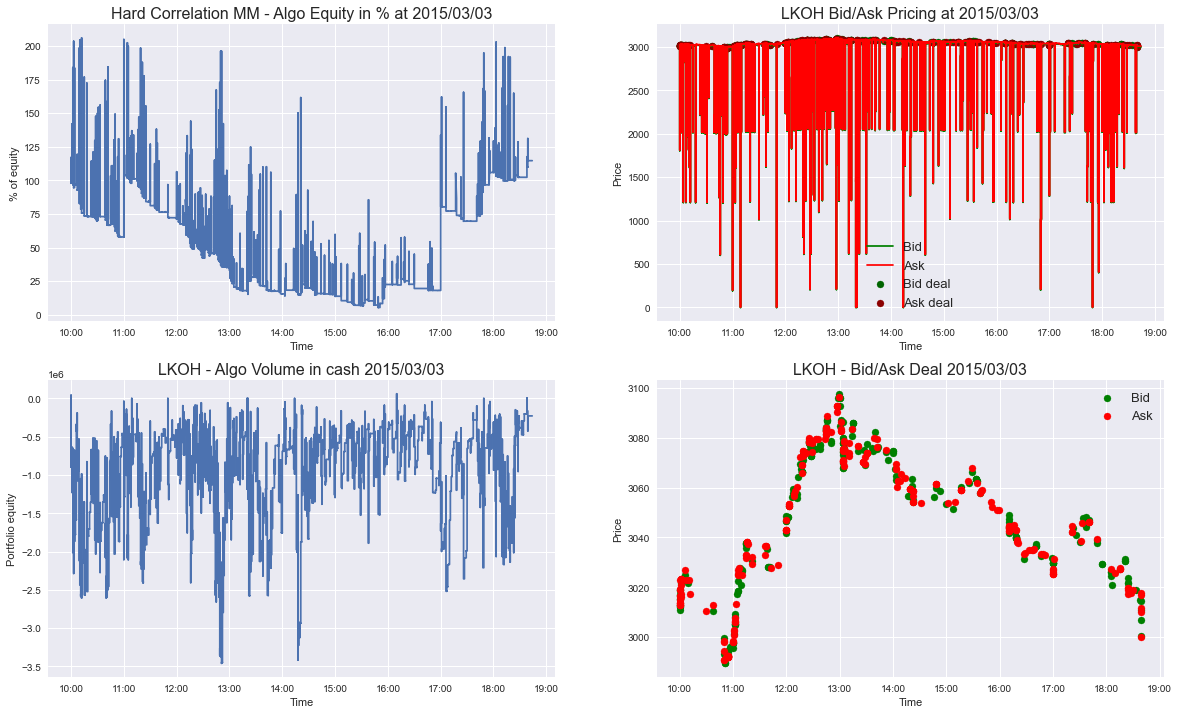

<Figure size 576x396 with 0 Axes>

In [43]:
import matplotlib.dates as mdates


def get_deal(raw):
    active_exec = raw[raw["NO"] == "mm"]
    passive_exec = raw[raw["NO"] != "mm"]
    
    bid_deal = pd.concat([active_exec[active_exec["BUYSELL"] == "B"], \
    passive_exec[passive_exec["BUYSELL"] == "S"]])
    ask_deal = pd.concat([active_exec[active_exec["BUYSELL"] == "S"], \
    passive_exec[passive_exec["BUYSELL"] == "B"]])
    
    return bid_deal["TIME"] // 100000, ask_deal["TIME"] // 100000, bid_deal["PRICE"], ask_deal["PRICE"]
    

def p_l_calc(raw, fair_price):
    # PL = Bought*(FP-AvgBid) + Sold*(AvgAsk-FP)
    active_exec = raw[raw["NO"] == "mm"]
    passive_exec = raw[raw["NO"] != "mm"]
    
    bought_vol = sum(active_exec[active_exec["BUYSELL"] == "B"]["VOLUME"]) + \
    sum(passive_exec[passive_exec["BUYSELL"] == "S"]["VOLUME"])
    sold_vol = sum(active_exec[active_exec["BUYSELL"] == "S"]["VOLUME"]) + \
    sum(passive_exec[passive_exec["BUYSELL"] == "B"]["VOLUME"])
    
    if bought_vol >= 1:
        avg_bought = (sum(active_exec[active_exec["BUYSELL"] == "B"]["TURNOVER"]) + \
        sum(passive_exec[passive_exec["BUYSELL"] == "S"]["TURNOVER"])) / bought_vol
    else:
        avg_bought = 0
    if sold_vol >= 1:
        avg_sold = (sum(active_exec[active_exec["BUYSELL"] == "S"]["TURNOVER"]) + \
        sum(passive_exec[passive_exec["BUYSELL"] == "B"]["TURNOVER"])) / sold_vol
    else:
        avg_sold = 0
    
    return round(bought_vol * (fair_price - avg_bought) + sold_vol * (avg_sold - fair_price), 1), \
            bought_vol, sold_vol, round(avg_bought), round(avg_sold)
    

def algo_stats(raw, fair_price, first_trade, algo, date, trade_log, dom, share="LKOH", bid_ask=False, show_deals=False):
    print("Stats for date -", date)
    print("Algo Params: ")
    print(algo.algo_params)
    print()
    print("Num of trades - ", raw.shape[0])
    print("Algo turnover - ", round(sum(raw["PRICE"] * raw["VOLUME"]), 1))
    p_l, bought_vol, sold_vol, avg_bought, avg_sold = p_l_calc(raw, fair_price)
    print("P&L Gross - ", p_l)
    print("P&L Net(with commision) -", round(p_l - sum(raw["PRICE"] * raw["VOLUME"]) * 0.00008, 1))
    print("Num of bought - ", bought_vol)
    print("Weighted average bought price - ", avg_bought)
    print("Num of sold - ", sold_vol)
    print("Weighted average sold price - ", avg_sold)
    print("Open Price - ", first_trade)
    print("Close price - ", dom.trade_log[-1][0])
    print("Initial cash - ", algo.first_cash)
    print("Total Return - ", round(100 * p_l / algo.first_cash, 2), "%", sep="")
    mpl.style.use("seaborn")
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axs[0, 0].set_title(algo.name + ' - Algo Equity in % at ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
    if algo.name[:4] != "Hard":
        print("End Cash - ", round(algo.cash))
        print("End Equity - ", round(algo.cash + (bought_vol - sold_vol) * fair_price))
        print("Max day Drawdown - ", round((min(algo.equity) / algo.first_cash - 1) * 100, 2), "%", sep ='')
        axs[0, 0].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.equity) / algo.first_cash * 100)
        axs[0, 1].set_title(share + " Price at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
        axs[1, 0].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.volume_lst))
    
    else:
        print("End Cash - ", round(algo.cash[share]))
        print("End Equity - ", round(algo.cash[share] + (bought_vol - sold_vol) * fair_price))
        print("Max day Drawdown - ", round((min(algo.equity[share]) / algo.first_cash - 1) * 100, 2), "%", sep ='')
        axs[0, 0].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.equity[share]) / algo.first_cash * 100)
        axs[0, 1].set_title(share + " Bid/Ask Pricing at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
        axs[1, 0].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.volume_lst[share]))
    
    axs[0, 1].plot(pd.to_datetime(trade_log["TIME"], format="%H%M%S%f"), trade_log["PRICE"])
    if bid_ask:
        if algo.name[:4] == "Hard":
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.bid_lst[share]), color="green", label="Bid")
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.ask_lst[share]), color="red", label="Ask")
        else:
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.bid_lst), color="green", label="Bid")
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.ask_lst), color="red", label="Ask")
        
        #axs[0, 1].scatter(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.baseline_lst[share]))
    axs[1, 0].set_title(share + ' - Algo Volume in cash ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('% of equity')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Price')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Portfolio equity')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Price')
    axs[1, 1].set_title(share + ' - Bid/Ask Deal ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
    time_bid, time_ask, bid_deal, ask_deal = get_deal(raw)
    axs[1, 1].scatter(pd.to_datetime(pd.Series(time_bid).astype(str), format="%H%M"), np.array(bid_deal), color="green", label="Bid")
    axs[1, 1].scatter(pd.to_datetime(pd.Series(time_ask).astype(str), format="%H%M"), np.array(ask_deal), color="red", label="Ask")
    axs[1, 1].legend(fontsize=13)    
    if show_deals:
        axs[0, 1].scatter(pd.to_datetime(pd.Series(time_bid).astype(str), format="%H%M"), np.array(bid_deal), color="darkgreen", label="Bid deal")
        axs[0, 1].scatter(pd.to_datetime(pd.Series(time_ask).astype(str), format="%H%M"), np.array(ask_deal), color="darkred", label="Ask deal")
    axs[0, 1].legend(fontsize=13)
    myFmt = mdates.DateFormatter('%H:%M')
    axs[0, 0].xaxis.set_major_formatter(myFmt)
    axs[0, 1].xaxis.set_major_formatter(myFmt)
    axs[1, 0].xaxis.set_major_formatter(myFmt)
    axs[1, 1].xaxis.set_major_formatter(myFmt)
    plt.show()
    plt.clf()

algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, share="LKOH", bid_ask=True, show_deals=True)


In [5]:
algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, bid_ask=True, show_deals=True, share="TATN")


NameError: name 'algo_stats' is not defined

In [6]:
len(algo.bid_lst["LKOH"])

NameError: name 'algo' is not defined

In [44]:
def day_stats(raw, fair_price, first_trade, algo, date, dom, share=None):
    output = dict()
    output["Date"] = date
    output["Num_of_trades"] =  raw.shape[0]
    output["Algo_turnover"] = round(sum(raw["PRICE"] * raw["VOLUME"]), 1)
    p_l, bought_vol, sold_vol, avg_bought, avg_sold = p_l_calc(raw, fair_price)
    output["P&L"] =  p_l
    output["Num_of_bought"] = bought_vol
    output["WA_bought_price"] = avg_bought
    output["Num_of_sold"] = sold_vol
    output["WA_sold_price"] = avg_sold
    output["Open_Price"] = first_trade
    output["Close_price"] = dom.trade_log[-1][0]
    output["Initial_cash"] = algo.first_cash
    if algo.name[:4] != "Hard":
        output["End_Cash"] = algo.cash
        output["End_Equity"] = algo.cash + (bought_vol - sold_vol) * fair_price
        output["Max_day_drawdown"] = round((min(algo.equity) / algo.first_cash - 1) * 100, 2)
    else:
        output["End_Cash"] = algo.cash[share]
        output["End_Equity"] = algo.cash[share] + (bought_vol - sold_vol) * fair_price
        output["Max_day_drawdown"] = round((min(algo.equity[share]) / algo.first_cash - 1) * 100, 2)

    output["Total_Return"] =  100 * p_l / algo.first_cash  
    return output
    
day_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, dom, share="LKOH")

{'Date': '20150303',
 'Num_of_trades': 482,
 'Algo_turnover': 27816751.0,
 'P&L': -4450.8,
 'Num_of_bought': 4595,
 'WA_bought_price': 3047,
 'Num_of_sold': 4536,
 'WA_sold_price': 3046,
 'Open_Price': 3009.0,
 'Close_price': 3015.4,
 'Initial_cash': 2000000,
 'End_Cash': 2522328.300000002,
 'End_Equity': 2700236.9000000022,
 'Max_day_drawdown': -94.61,
 'Total_Return': -0.22254}

In [ ]:
real_trade = pd.read_csv("/Users/a185583357/Downloads/lkoh_03_03.csv", sep=',')
lkoh_real = real_trade[real_trade["tradedate"] == "3/3/2015"]
plt.figure(figsize=(20,20))
lkoh_real[lkoh_real["price"] == 2990.0]


In [51]:
records[1]

{'NO': 18,
 'SECCODE': 'VTBR',
 'BUYSELL': 'S',
 'TIME': 100000000000,
 'ORDERNO': 18,
 'ACTION': 1,
 'PRICE': 0.08827,
 'VOLUME': 40000,
 'TRADENO': 'nan',
 'TRADEPRICE': nan,
 'DATE': '20150527'}

In [ ]:
trade_log.shape

In [ ]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H%M')
ax.xaxis.set_major_formatter(myFmt)

plt.figure(figsize=(20,20))
plt.grid()
tmp = trade_log[trade_log["TIME"] < 120000000]
plt.scatter(pd.to_datetime(tmp["TIME"], format="%H%M%S%f"), tmp["PRICE"])

# Теперь попробуем прогнать годовой бектест и прикрутить для него статистики

In [ ]:
outp = backtest_year('20150324', dom, Basic_MM(), enddate="20150401")

In [ ]:
outp = backtest_year('20150301', dom, Basic_MM())

In [ ]:
pd.DataFrame(outp).to_csv("basic_mm_fst.csv")

In [ ]:
res_log = pd.DataFrame(outp).set_index("Date")
res_log

In [ ]:
df = res_log.copy()
df['downside_returns'] = 0
df.loc[df['Total_Return'] < 0, 'downside_returns'] = df['Total_Return']**2
expected_return = df['Total_Return'].mean()
down_stdev = np.sqrt(df['downside_returns'].mean())
sortino_ratio = (expected_return - 0)/down_stdev
print(sortino_ratio)

Stats for date - 20150302 - 20150902
Algo Params: 


Algo name - Basic MM
Spread - 0.5%,
SMA tick length - 300,
Order volume - 30,
Speed of orders - 3ms.
Duration - 184 days
Initial cash - 1000000

Algo Turnover - 515124886
P&L Net - 225852
P&L Gross - 267062
Total algo return gross - 13.35%
Buy & Hold Return - -3.04%
Begin price of LKOH - 318.85
End price of LKOH - 309.15
Geometric mean Day Return - 0.07%
Sharp ratio - 0.06
Sortino ratio - 0.09
Calmar ratio - 1.0
Max Drawdown at day - -5.82%
Peak to Valley Drawdown - -13.41%
Equity final - 1121390
Equity peak - 1150436


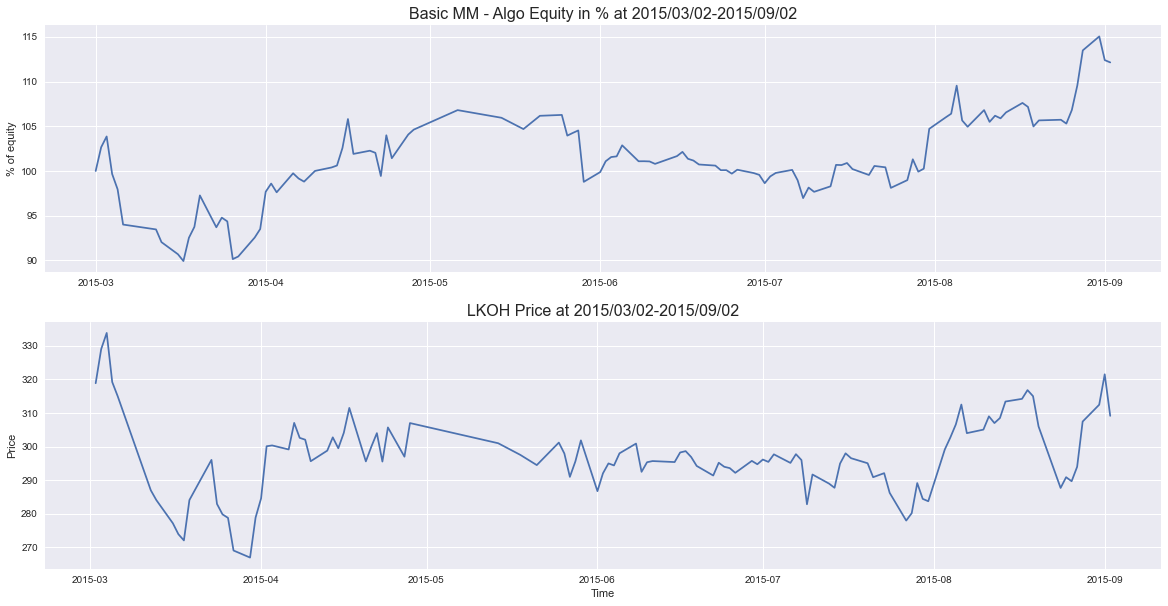

,0,downside_returns
0,-6.126100,37.529101
1,11.702625,0.000000
2,-5.520950,30.480889
3,0.838350,0.000000
4,5.289875,0.000000
5,9.699325,0.000000
6,-2.530025,6.401027


<Figure size 576x396 with 0 Axes>

In [45]:
def advance_stats(res_log, risk_free=0.5):
    """
    df = res_log.copy()
    df["Total_Return"] = df["Total_Return"] / 100
    #print(df["Total_Return"].mean(), df["Total_Return"].std())
    month_data = pd.DataFrame(np.array(df["Total_Return"].groupby([lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").year,
                            lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").month]).sum()))
    month_data['downside_returns'] = 0
    month_data.loc[month_data[0] < 0, 'downside_returns'] = month_data[0]**2

    expected_return = month_data[0].mean()
    down_stdev = np.sqrt(month_data["downside_returns"].mean())
    sortino_ratio = (expected_return - risk_free)/down_stdev
    """
    df = deepcopy(res_log)
    df = df[~df.index.duplicated()]
    df['downside_returns'] = 0
    df.loc[df['Total_Return'] < risk_free, 'downside_returns'] = df['Total_Return']**2
    expected_return = df['Total_Return'].mean()
    down_stdev = np.sqrt(df['downside_returns'].mean())
    sortino_ratio = (expected_return - risk_free)/down_stdev
    sharp_ratio = (res_log["Total_Return"].mean() - risk_free) / res_log["Total_Return"].std()
    #print(res_log["Total_Return"].mean())
    #print(res_log["Total_Return"])
    #sharp_ratio = (month_data[0].mean() - risk_free) / month_data[0].std()#)+'/'+str(df["Total_Return"].std())+'/'+str(df["Total_Return"].mean())
    total_return = max(sum(res_log["Total_Return"]), -100)#(np.prod(np.array((100 + res_log["Total_Return"])/100)) - 1) * 100
    try:
        duration = (pd.to_datetime(res_log.index.astype(int), format="%Y%m%d")[-1] - pd.to_datetime(res_log.index.astype(int), format="%Y%m%d")[0]).days
    except:
        print(res_log.index)
        raise Exception
    geom_return = ((1 + total_return/100) ** (1/duration) - 1) * 100
    p_l = res_log["P&L"].sum()
    buy_and_hold = ((res_log["Open_Price"][res_log.index[-1]] - res_log["Open_Price"][res_log.index[0]]) / res_log["Open_Price"][res_log.index[0]]) * 100
    return sharp_ratio, sortino_ratio, geom_return, total_return, duration, p_l, buy_and_hold


def year_stats(res_log, algo, risk_free=0.00, share=None):
    print("Stats for date -",res_log.index[0], '-', res_log.index[-1] )
    sharp_ratio, sortino_ratio, geom_return, \
    total_return, duration, p_l, buy_and_hold = advance_stats(res_log, risk_free)
    actual_equity = algo.first_cash
    equity_lst = [actual_equity]
    for j in res_log["Total_Return"]:
        equity_lst.append(actual_equity * (1 + j / 100))
        actual_equity = equity_lst[-1]
    max_draw_lst = [None] * len(equity_lst)
    for i in range(len(equity_lst)):
        max_draw_lst[i] = 100*(min(equity_lst[i:]) - equity_lst[i]) / equity_lst[i] 
    #peak_valley = 100*(min(equity_lst) - max(equity_lst)) / max(equity_lst)
    peak_valley = min(max_draw_lst)   
    
    print("Algo Params: ")
    print(algo.algo_params)
    print("Duration -", duration, "days")
    print("Initial cash -", algo.first_cash)
    print()
    print("Algo Turnover -", round(res_log["Algo_turnover"].sum()))
    print("P&L Net -", round(p_l - round(res_log["Algo_turnover"].sum()) * 0.00008))
    print("P&L Gross -", round(p_l))
    print("Total algo return gross - ", round(total_return, 2), "%", sep='')
    print("Buy & Hold Return - ", round(buy_and_hold, 2), "%", sep='')
    if not share:
        share = algo.share_name
    print("Begin price of", share, "-", res_log["Open_Price"][res_log.index[0]])
    print("End price of", share, "-", res_log["Open_Price"][res_log.index[-1]])
    print("Geometric mean Day Return - ", round(geom_return, 2), "%", sep='')
    print("Sharp ratio -", round(sharp_ratio, 2))
    print("Sortino ratio -", round(sortino_ratio, 2))
    print("Calmar ratio -", -round(total_return / peak_valley, 2))
    print("Max Drawdown at day - ", min(res_log["Max_day_drawdown"]), "%", sep='')
    print("Peak to Valley Drawdown - ", round(min(total_return, peak_valley,  min(res_log["Max_day_drawdown"])), 2), '%', sep='')
    print("Equity final -", round(equity_lst[-1]))
    print("Equity peak -", round(max(equity_lst)))
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    date = res_log.index[0]
    end_date = res_log.index[-1]
    axs[0].set_title(algo.name + ' - Algo Equity in % at ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:]\
                     + "-" + str(end_date)[:4] + "/" + str(end_date)[4:6] + "/" + str(end_date)[6:], size=16)
    #res_log[i] for hard model
    times = pd.to_datetime(pd.concat([pd.Series(int(res_log.index[0]) - 1), pd.Series(res_log.index)]), format="%Y%m%d")
    axs[0].plot(times, np.array(equity_lst) / algo.first_cash * 100)
    axs[1].set_title(share + " Price at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:] \
                     + "-" + str(end_date)[:4] + "/" + str(end_date)[4:6] + "/" + str(end_date)[6:], size=16)
    axs[1].plot(pd.to_datetime(res_log.index, format="%Y%m%d"), res_log["Open_Price"])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('% of equity')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Price')
    plt.show()
    plt.clf()
    
    
    
path= "optimizations/hard_res/LKOH TATN/WMAtanh10/y-20150301-20150902LKOHspr=0.005-0.007B-2q_max571TATNspr=0.002-0.004B-2q_max4971.csv"#)["TATN"]).set_index("Date")
tmp = list(pd.read_csv(path)["TATN"])
res_share = []
for day_st in tmp:
    res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
df = pd.DataFrame(res_share).set_index("Date").drop_duplicates()

year_stats(df, Basic_MM())
#year_stats(tmp_res, Basic_MM(), share="LKOH")
month_data = pd.DataFrame(np.array(df["Total_Return"].groupby([lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").year,
                            lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").month]).sum()))
month_data['downside_returns'] = 0
month_data.loc[month_data[0] < 0, 'downside_returns'] = month_data[0]**2
month_data

Stats for date - 20150902 - 20160229
Algo Params: 


Algo name - Basic MM
Spread - 0.5%,
SMA tick length - 300,
Order volume - 30,
Speed of orders - 3ms.
Duration - 180 days
Initial cash - 1000000

Algo Turnover - 213236876.0
P&L Net - 44187.0
P&L Gross - 61246.0
Total algo return gross - 3.06%
Buy & Hold Return - 5.74%
Begin price of LKOH - 2438.0
End price of LKOH - 2578.0
Geometric mean Day Return - 0.02%
Sharp ratio - 0.31
Sortino ratio - 1.04
Calmar ratio - 1.24
Max Drawdown at day - -1.89%
Peak to Valley Drawdown - -2.47%
Equity final - 1030279
Equity peak - 1032083


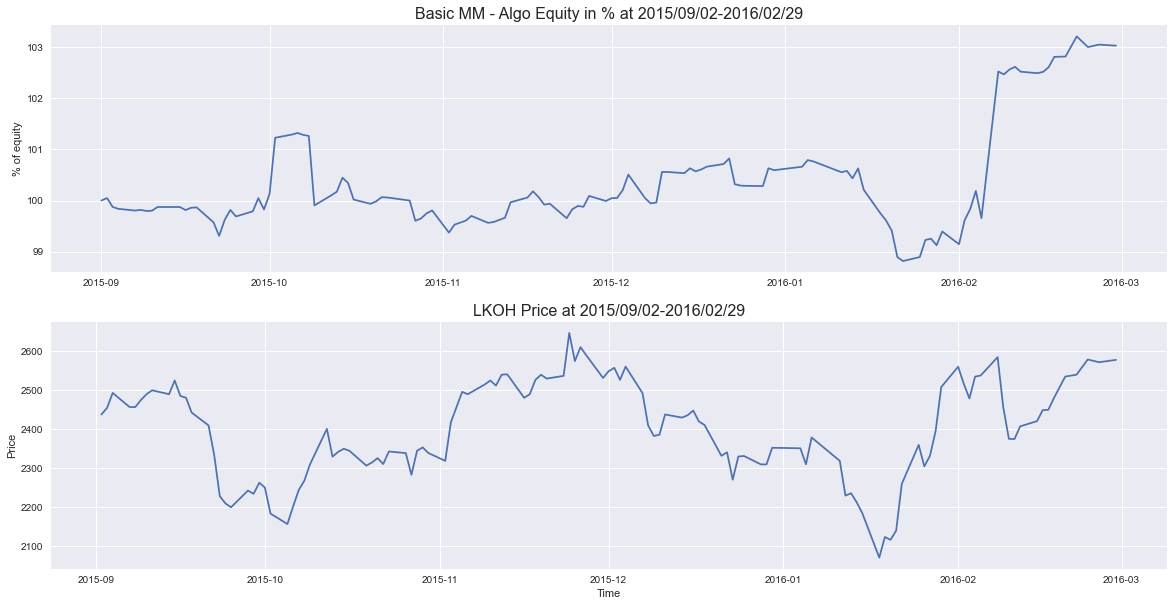

,0,downside_returns
0,-0.171120,0.029282
1,-0.002900,0.000008
2,0.188240,0.035434
3,0.605930,0.000000
4,-1.192805,1.422784
5,3.634975,0.000000


<Figure size 576x396 with 0 Axes>

In [261]:
    
df = pd.read_csv("optimizations/basic_res/LKOH/year20150901-20160302 spread - 0.003 sma tick len - 5.csv").set_index("Date")

year_stats(df, Basic_MM())
#year_stats(tmp_res, Basic_MM(), share="LKOH")
month_data = pd.DataFrame(np.array(df["Total_Return"].groupby([lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").year,
                            lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").month]).sum()))
month_data['downside_returns'] = 0
month_data.loc[month_data[0] < 0.5, 'downside_returns'] = month_data[0]**2
month_data

In [247]:
pd.DataFrame(pd.read_csv("optimizations/hard_res/LKOH TATN/WMAtanh10/y-20150301-20150902LKOHspr=0.002-0.004B-2q_max190TATNspr=0.0015-0.0035B-2q_max1657.csv")["TATN"])


,TATN
0,"{'Date': '20150302', 'Num_of_trades': 262, 'Al..."
1,"{'Date': '20150303', 'Num_of_trades': 323, 'Al..."
2,"{'Date': '20150317', 'Num_of_trades': 194, 'Al..."
3,"{'Date': '20150318', 'Num_of_trades': 220, 'Al..."
4,"{'Date': '20150319', 'Num_of_trades': 263, 'Al..."
5,"{'Date': '20150320', 'Num_of_trades': 468, 'Al..."
6,"{'Date': '20150323', 'Num_of_trades': 323, 'Al..."
7,"{'Date': '20150325', 'Num_of_trades': 201, 'Al..."
8,"{'Date': '20150326', 'Num_of_trades': 381, 'Al..."
9,"{'Date': '20150327', 'Num_of_trades': 213, 'Al..."


In [ ]:
res_log

In [ ]:
np.array((res_log["P&L "]))

# Теперь напишем алгоритм полос боллинджера

In [46]:
class Bollinger_Bands_MM:
    def __init__(self, spread=0.004, min_spread=0.004, barriers=None, sma_len=30, basic_volume=3, cash=1000000, name="Bollinger Bands MM"):
        self.name = name
        self.cash = cash
        self.first_cash = cash
        self.equity = []
        self.time = []
        self.num_of_shares = 0
        self.spread = spread
        self.min_spread = min_spread
        self.spread_lst = []
        self.sma_len = sma_len
        self.basic_volume = basic_volume
        self.baseline_price = None
        self.baseline_lst = []
        self.volume_lst = []
        self.ask_lst = []
        self.bid_lst = []
        self.num_of_std = 2
        self.ask_price_1 = 0
        self.ask_volume_1 = 0
        self.bid_price_1 = 0
        self.bid_volume_1 = 0
        self.bid_order_num = 0
        self.ask_order_num = 0
        self.bid_last_price = None
        self.ask_last_price = None
        self.last_trade_num = None
        self.trigger_time = None
        self.latency_moex = 3
        self.algo_params = "\n\nAlgo name - " + self.name + "\nMin spread - " + str(self.min_spread) + ",\n" + \
                            "SMA tick length - " + str(sma_len) +",\n" + "Order volume - " + str(basic_volume) + \
                            "\nNum of std in spread - " + str(self.num_of_std) + ",\nSpeed of orders - " + str(self.latency_moex) + "ms."
        self.share_name = "LKOH"
        
    
    def trading(self, dom, time=100000000, first_sma=0, is_plot=False, is_PL=False):
        if not self.baseline_price:
            self.create_pre_trade_value(first_sma)
            return self.generate_orders()
        else:
            if len(dom.trade_log) < 3:       
                if not self.share_name:
                    self.share_name = dom.share_name
                    self.algo_params = "Share name - " + dom.share_name + self.algo_params
                self.equity.append(self.cash + self.num_of_shares * self.baseline_price)
            else:
                self.equity.append(self.cash + self.num_of_shares * dom.trade_log[-1][0])
            self.time.append(time // 100000)
            self.volume_lst.append(self.num_of_shares * self.baseline_price)
            if len(dom.trade_log) > 3:
                if self.last_trade_num == dom.trade_log[-1][-2]:
                    pass
                elif self.trigger_time == None:
                    self.trigger_time = int(dom.trade_log[-1][-3]) + self.latency_moex
                elif int(self.trigger_time) + 100 > time:
                    #print("dsf")
                    pass
                else:
                    #print(time)
                    self.trigger_time = None
                    self.last_trade_num = dom.trade_log[-1][-2]
                    self.calc_bid_ask(dom.trade_log)
                    self.bid_lst.append(self.bid_price_1)
                    self.ask_lst.append(self.ask_price_1)
                    return self.generate_orders(time)
            self.bid_lst.append(self.bid_price_1)
            self.ask_lst.append(self.ask_price_1)
        return []
        
    
    def create_pre_trade_value(self, first_sma):
        self.baseline_price = first_sma
        self.baseline_lst.append(self.baseline_price)
        self.ask_price_1 = round(self.baseline_price * (1 + self.spread/2), 1)
        self.bid_price_1 = round(self.baseline_price  * (1 - self.spread/2), 1)
        self.ask_volume_1 = self.basic_volume
        self.bid_volume_1 = self.basic_volume
        
        
    def calc_bid_ask(self, trade_log):
        if len(trade_log) < 3:
            pass
        else:
            #TODO trde log накапливается и эта операция становиться сложной
            self.baseline_price = np.array(trade_log[-self.sma_len:])[:, 0].astype(float).mean()
            self.baseline_lst.append(self.baseline_price)
            std_len = min(len(self.baseline_lst), len(trade_log), self.sma_len)
            self.spread = max((np.array(trade_log[-std_len:])[:, 0].astype(float) \
            - np.array(self.baseline_lst[-std_len:])).std() * self.num_of_std, self.baseline_price * self.min_spread)
            self.spread_lst.append(self.spread)
            self.ask_price_1 = round(self.baseline_price + self.spread/2, 1)
            self.bid_price_1 = round(self.baseline_price  - self.spread/2, 1)
            self.ask_volume_1 = self.basic_volume
            self.bid_volume_1 = self.basic_volume
       
    
    def generate_orders(self, time=100000000):
        bid_cancel, ask_cancel, bid_place, ask_place = dict(), dict(), dict(), dict()
        bid_cancel["BUYSELL"] = "B"
        bid_place["BUYSELL"] = "B"
        ask_cancel["BUYSELL"] = "S"
        ask_place["BUYSELL"] = "S"
        bid_cancel["ACTION"] = 0
        bid_place["ACTION"] = 1
        ask_cancel["ACTION"] = 0
        ask_place["ACTION"] = 1
        
        if self.bid_last_price:
            bid_cancel["PRICE"] = self.bid_last_price
            bid_cancel["ORDERNO"] = "myorder" + str(self.bid_order_num)
            ask_cancel["PRICE"] = self.ask_last_price
            ask_cancel["ORDERNO"] = "myorder" + str(self.ask_order_num)
            self.bid_order_num += 1
            self.ask_order_num += 1
        
        bid_place["PRICE"] = self.bid_price_1
        ask_place["PRICE"] = self.ask_price_1
        bid_place["TIME"] = time
        ask_place["TIME"] = time
        bid_place["VOLUME"] = self.bid_volume_1
        ask_place["VOLUME"] = self.ask_volume_1
        bid_place["ORDERNO"] = "myorder" + str(self.bid_order_num)
        ask_place["ORDERNO"] = "myorder" + str(self.ask_order_num)
        bid_place["NO"] = "mm"
        ask_place["NO"] = "mm"
        self.bid_last_price = self.bid_price_1
        self.ask_last_price = self.ask_price_1
        
        
        if int(self.cash) < int(self.bid_price_1 * self.bid_volume_1):
            #print("No cash")
            return [ask_cancel, ask_place]
        elif int(self.cash) > int(self.ask_price_1 * self.ask_volume_1) + 2 * int(self.first_cash):
            #print("Too much shorts")
            return [bid_cancel,bid_place]
        elif self.bid_order_num != 0:
            return [bid_cancel, ask_cancel, bid_place, ask_place]
        else:
            return [bid_place, ask_place]
        
        
    def change_cash_share(self, new_trades):
        if not new_trades or len(new_trades) == 0 or new_trades[0] == None:
            return self.cash, self.num_of_shares

        trade_log = np.array(new_trades)

        active_exec = trade_log[np.where(trade_log[:,6] == "mm")]
        passive_exec = trade_log[np.where(trade_log[:,3] == "mm_past")]
        if active_exec.shape[0] + passive_exec.shape[0] == 0:
            return self.cash, self.num_of_shares
        if active_exec.shape[0] > 0:
            self.num_of_shares += np.sum(active_exec[np.where(active_exec[:,7] == "B")][:,1].astype(np.float)) - np.sum(active_exec[np.where(active_exec[:,7] == "S")][:,1].astype(np.float))
            self.cash += np.sum(active_exec[np.where(active_exec[:,7] == "S")][:,4].astype(np.float)) - np.sum(active_exec[np.where(active_exec[:,7] == "B")][:,4].astype(np.float))
        if passive_exec.shape[0] > 0:
            self.cash += np.sum(passive_exec[np.where(passive_exec[:,7] == "B")][:,4].astype(np.float)) - np.sum(passive_exec[np.where(passive_exec[:,7] == "S")][:,4].astype(np.float))
            self.num_of_shares += np.sum(passive_exec[np.where(passive_exec[:,7] == "S")][:,1].astype(np.float)) - np.sum(passive_exec[np.where(passive_exec[:,7] == "B")][:,1].astype(np.float))

        return self.cash, self.num_of_shares
        
            

In [18]:
from tqdm import tqdm 


dom = Matching_Engine()
errors = 0

isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
#TODO внедрить задержки для ММ
latency = 3 # ms
algo = Bollinger_Bands_MM(min_spread=10, basic_volume=100, cash=10000000)
algo_errors = 0
algo_orders = None

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if algo_orders and int(record["TIME"]) > algo_orders[-1]["TIME"] + latency:
        out_algo = []
        for order in algo_orders:
            order["DATE"] = date
            try:
                out = dom.check_order(order)
                if out:
                    out_algo.extend(out)
            except KeyboardInterrupt:
                break
            except:
                if order["ACTION"] == 1:
                    print("MAYBE Some problem, cant add order")
                    raise Exception
                algo_errors += 1
        algo_orders = None
        if len(out_algo) > 0:
            algo.change_cash_share(out_algo)
   
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
        algo.change_cash_share(out)
    except KeyboardInterrupt:
        break
    except:
        errors += 1
    if not algo_orders:
        algo_orders = algo.trading(dom, time=record["TIME"], first_sma=max(records[1000]["PRICE"], records[1001]["PRICE"]))

100%|██████████| 934115/934115 [00:11<00:00, 81137.89it/s] 


100%|██████████| 934115/934115 [00:10<00:00, 88005.86it/s] 


Num of historic reject -  35 , algo reject -  2
--- 28.396421909332275 overall seconds ---
Stats for date - 20150731
Algo Params: 


Algo name - Bollinger Bands MM
Min spread - 10,
SMA tick length - 30,
Order volume - 100
Num of std in spread - 2,
Speed of orders - 3ms.

Num of trades -  3
Algo turnover -  501130.0
P&L Gross -  130.0
P&L Net(with commision) - 89.9
Num of bought -  100
Weighted average bought price -  2505
Num of sold -  100
Weighted average sold price -  2506
Open Price -  2437.8
Close price -  2529.0
Initial cash -  10000000
Total Return - 0.0%
End Cash -  10000130.0
End Equity -  10000130.0
Max day Drawdown - -0.0%


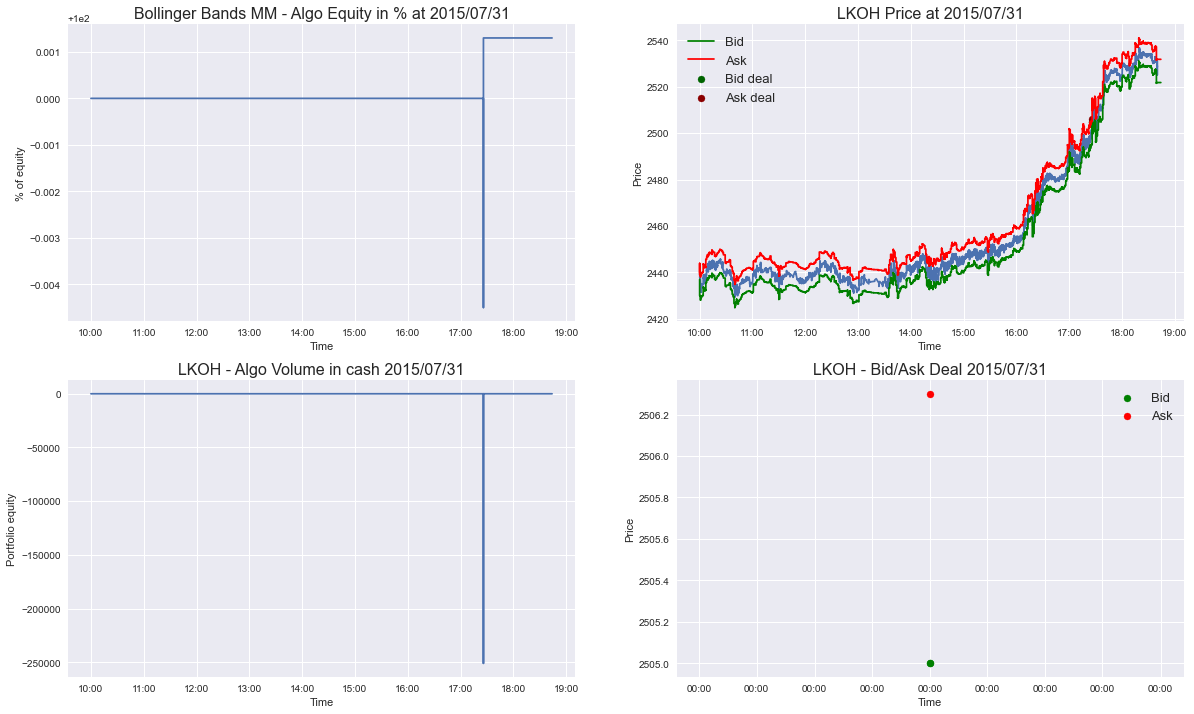

NameError: name 'day_stats' is not defined

<Figure size 576x396 with 0 Axes>

In [23]:
algo_name = "Boll"
start_date = "20150730"
enddate = "20150731"
share_def = "LKOH"
show_graph = True
params = dict()
params["basic_volume"] = 100
params["cash"] = 10000000
params["min_spread"] = 10

backtest_year(start_date, Matching_Engine(), Bollinger_Bands_MM(**params), enddate=enddate, share=share_def, show_stat=show_graph)

100%|██████████| 934115/934115 [00:57<00:00, 16110.62it/s]


Num of historic reject -  310 , algo reject -  286
--- 74.5885980129242 overall seconds ---
Stats for date - 20150731
Algo Params: 


Algo name - Bollinger Bands MM
Min spread - 0.004166666,
SMA tick length - 1000,
Order volume - 100
Num of std in spread - 2,
Speed of orders - 3ms.

Num of trades -  687
Algo turnover -  83313010.6
P&L Gross -  -222910.2
P&L Net(with commision) - -229575.2
Num of bought -  15046
Weighted average bought price -  2435
Num of sold -  19108
Weighted average sold price -  2443
Open Price -  2437.8
Close price -  2529.0
Initial cash -  10000000
Total Return - -2.23%
End Cash -  20049888.0
End Equity -  9777090.0
Max day Drawdown - -2.56%


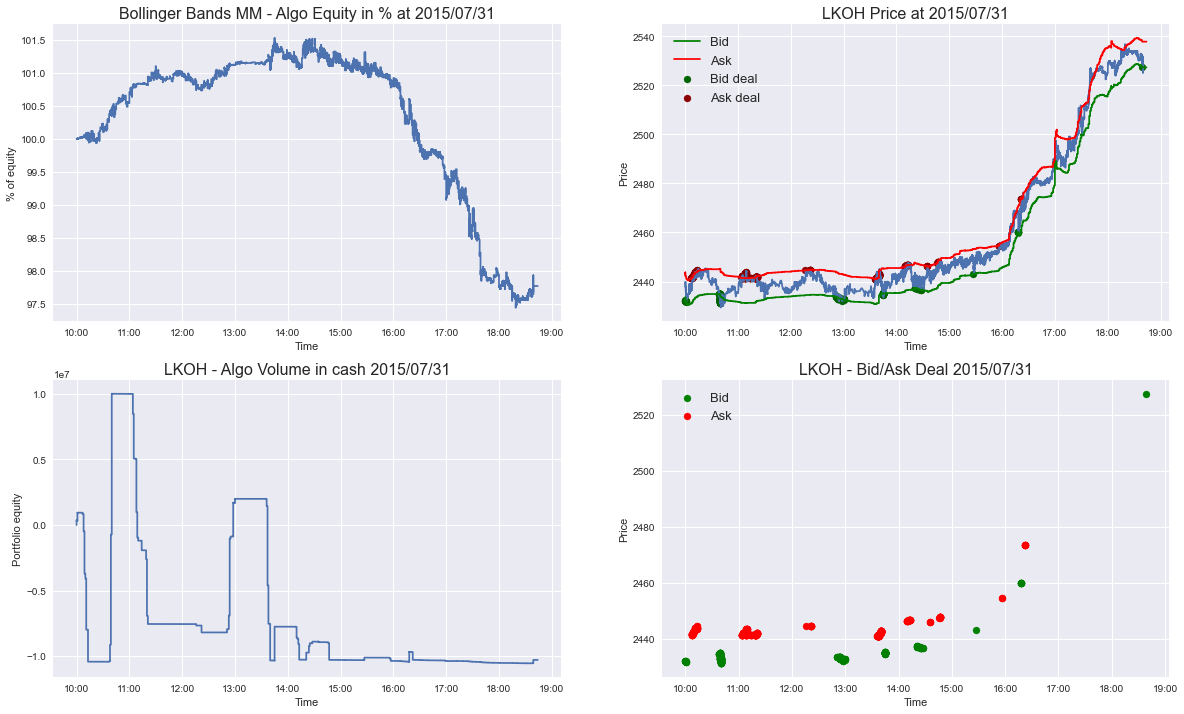

NameError: name 'day_stats' is not defined

<Figure size 576x396 with 0 Axes>

In [27]:
algo_name = "Boll"
start_date = "20150730"
enddate = "20150731"
share_def = "LKOH"
show_graph = True
params = dict()
params["basic_volume"] = 100
params["cash"] = 10000000
params["sma_len"] = 1000
params["min_spread"] = 0.004166666

backtest_year(start_date, Matching_Engine(), Bollinger_Bands_MM(**params), enddate=enddate, share=share_def, show_stat=show_graph)

In [79]:
trade_log = pd.DataFrame((dom.trade_log), 
             columns=["PRICE", 'VOLUME', 'NEW-ORDER-ID', 'PAST-ORDER-ID',"TURNOVER","TIME",'NO', 'BUYSELL'])

algo_raw = pd.concat([trade_log[trade_log["NEW-ORDER-ID"].apply(isinstance, args=(str,))], 
                      trade_log[trade_log["PAST-ORDER-ID"].apply(isinstance, args=(str,))]])
algo_raw.head()

,PRICE,VOLUME,NEW-ORDER-ID,PAST-ORDER-ID,TURNOVER,TIME,NO,BUYSELL


Stats for date - 20150731
Algo Params: 


Algo name - Bollinger Bands MM
Min spread - 10,
SMA tick length - 30,
Order volume - 100
Num of std in spread - 2,
Speed of orders - 3ms.

Num of trades -  0
Algo turnover -  0
P&L Gross -  0.0
P&L Net(with commision) - 0.0
Num of bought -  0
Weighted average bought price -  0
Num of sold -  0
Weighted average sold price -  0
Open Price -  2437.8
Close price -  2496.5
Initial cash -  10000000
Total Return - 0.0%
End Cash -  10000000
End Equity -  10000000
Max day Drawdown - 0.0%


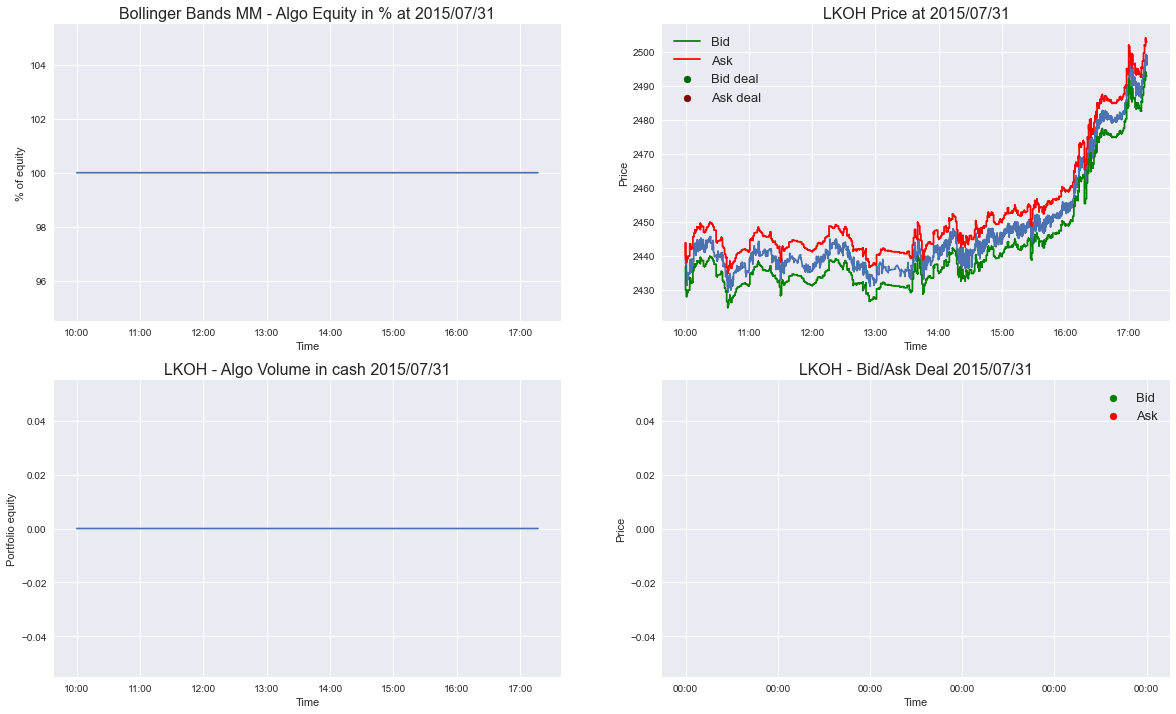

<Figure size 576x396 with 0 Axes>

In [80]:
algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, bid_ask=True, show_deals=True)

In [ ]:
algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, bid_ask=True, show_deals=True)

# Посмотри на боллинджера на годовых данных

In [ ]:
outp = backtest_year('20150301', dom, Bollinger_Bands_MM(), enddate="20150401")

In [ ]:
res_log = pd.DataFrame(outp).set_index("Date")

In [ ]:
year_stats(res_log, algo)

# Настроим одновременную торговлю на нескольких стаканах для сложной модели

In [ ]:
fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog20150303/OrderLog20150303.txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
date = "20150303"
fol['DATE'] = date
lkoh = fol[fol["SECCODE"] == "LKOH"]
tatn = fol[fol["SECCODE"] == "TATN"]
rosn = fol[fol["SECCODE"] == "ROSN"]
vtbr = fol[fol["SECCODE"] == "VTBR"]
portfolio = pd.concat([lkoh, rosn, tatn, vtbr])
portfolio = portfolio.sort_values(by='NO')
records = portfolio.to_dict("records")

In [ ]:
records[-19999]

### По идее это просто одновременная торговля по нескольким акциям которые вообще друг от друга не зависят. Значит будет достаточно создать несколько Matching Engine, объединить все логи по акциям сортировав по времени и на каждый ордер определять к какому именно Matching engine его кидать.

In [ ]:
dom_lkoh, dom_rosn, dom_tatn, dom_vtbr = Matching_Engine(), Matching_Engine(), Matching_Engine(), Matching_Engine()
algo_lkoh, algo_rosn, algo_tatn, algo_vtbr = Bollinger_Bands_MM(), Bollinger_Bands_MM(), Bollinger_Bands_MM(), Bollinger_Bands_MM()

isebergs_lkoh = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
isebergs_rosn = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + "rosn" + date + ".csv", index_col=0).to_dict()["vol"]
isebergs_tatn = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + "tatn" + date + ".csv", index_col=0).to_dict()["vol"]
isebergs_vtbr = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + "vtbr" + date + ".csv", index_col=0).to_dict()["vol"]

matchine_engines = dict()
matchine_engines["LKOH"] = [dom_lkoh, isebergs_lkoh, 0, algo_lkoh, None, 0]
matchine_engines["ROSN"] = [dom_rosn, isebergs_rosn, 0, algo_rosn, None, 0]
matchine_engines["TATN"] = [dom_tatn, isebergs_tatn, 0, algo_tatn, None, 0]
matchine_engines["VTBR"] = [dom_vtbr, isebergs_vtbr, 0, algo_vtbr, None, 0]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    dom, isebergs, algo, algo_orders = matchine_engines[record["SECCODE"]][0], \
    matchine_engines[record["SECCODE"]][1], matchine_engines[record["SECCODE"]][3], matchine_engines[record["SECCODE"]][4]
    if algo_orders and int(record["TIME"]) > algo_orders[-1]["TIME"] + latency:
        out_algo = []
        for order in algo_orders:
            order["DATE"] = date
            try:
                out = dom.check_order(order)
                if out:
                    out_algo.extend(out)
            except KeyboardInterrupt:
                break
            except:
                if order["ACTION"] == 1:
                    raise Exception
                matchine_engines[record["SECCODE"]][5] += 1
        matchine_engines[record["SECCODE"]][4] = None
        if len(out_algo) > 0:
            algo.change_cash_share(out_algo)
   
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
        algo.change_cash_share(out)
    except KeyboardInterrupt:
        break
    except:
        matchine_engines[record["SECCODE"]][2] += 1
    if not matchine_engines[record["SECCODE"]][4]:
        matchine_engines[record["SECCODE"]][4] = algo.trading(dom, time=record["TIME"], first_sma=records[1000]["PRICE"])

In [ ]:
matchine_engines["LKOH"][2], matchine_engines["ROSN"][2], matchine_engines["TATN"][2], matchine_engines["VTBR"][2]

In [ ]:
sec_lst = ["LKOH", "ROSN", "TATN", "VTBR"]

for sec in sec_lst:
    dom, algo = matchine_engines[sec][0], matchine_engines[sec][3]
    trade_log = pd.DataFrame((dom.trade_log), 
                 columns=["PRICE", 'VOLUME', 'NEW-ORDER-ID', 'PAST-ORDER-ID',"TURNOVER","TIME",'NO', 'BUYSELL'])

    algo_raw = pd.concat([trade_log[trade_log["NEW-ORDER-ID"].apply(isinstance, args=(str,))], 
                          trade_log[trade_log["PAST-ORDER-ID"].apply(isinstance, args=(str,))]])
    algo_raw
    algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log)

# Соберем сложную модель

### Его описание можно найти в презентации

In [50]:
def create_empty_dict(share_names, content):
    output = dict()
    for share in share_names:
        output[share] = deepcopy(content)
    return output



In [63]:
print("me declined - ", matching_engines[share_lst[0]][2], matching_engines[share_lst[1]][2],
      '\nalgo declined -', 
      matching_engines[share_lst[0]][5], matching_engines[share_lst[1]][5])

me declined -  73 21 
algo declined - 294 97


In [53]:
print("me declined - ", matching_engines[share_lst[0]][2], matching_engines[share_lst[1]][2],
      '\nalgo declined -', 
      matching_engines[share_lst[0]][5], matching_engines[share_lst[1]][5])

me declined -  73 21 
algo declined - 294 97


# Сделаем версию годового бектеста для сложных алгоритмов

In [ ]:
res_backtest = hard_backtest_year("20150301", hyperparams, corr_matrix, share_lst, enddate="20160302") 

In [ ]:
pd.DataFrame(res_backtest).to_csv("hard_corr_year.csv")

In [ ]:
#TODO проблема с TATN на дате 20150403
res_basic = backtest_year('20150301', Matching_Engine(), Basic_MM(basic_volume=100), enddate="20160301", share="LKOH", show_stat=True)
pd.DataFrame(res_basic).to_csv("basic_mm_tatn_year.csv")
res_bollinger = backtest_year('20150301', Matching_Engine(), Bollinger_Bands_MM(basic_volume=100), enddate="20160301", share="LKOH", show_stat=True)

pd.DataFrame(res_bollinger).to_csv("bollinger_res_tatn_year.csv")

In [ ]:
#res_basic = pd.read_csv("basic_mm_sec.csv", index_col=["Date"])
res_boll = pd.read_csv("bollinger_res_tatn_year.csv", index_col=["Date"])

In [ ]:
year_stats(res_boll, Bollinger_Bands_MM())

In [ ]:
import json

corr_share = "LKOH"
tmp = list(pd.read_csv("hard_corr_year.csv")[corr_share])
res_corr = []
for day_st in tmp:
    res_corr.append(dict(json.loads(day_st.replace('\'', '\"'))))
res_corr

In [ ]:
res_lkoh = []
for day_stat in res_backtest:
    res_lkoh.append(day_stat["LKOH"])
res_lkoh

In [ ]:
year_stats(pd.DataFrame(res_corr).set_index("Date"), Hard_Correlation_MM(hyperparams, corr_matrix), share=corr_share)

In [ ]:
pd.DataFrame(final).set_index("Date")["Open_Price"][pd.DataFrame(final).set_index("Date").index[0]]

# Агрегируем годовые статистики по разным алгоритмам

In [47]:
def compare_algo(res_lst, algo_lst, risk_free=0.00, share="LKOH", print_params=False):
    print("Stats for date -",res_lst[0].index[0], '-', res_lst[0].index[-1])
    if print_params:
        print("Algo Info: ")
        for i in range(len(algo_lst)):
            print(i + 1, ') ', algo_lst[i].algo_params, sep='')
            print()
    stat_res = dict()
    for i in range(len(res_lst)):
        res_log = res_lst[i][~res_lst[i].index.duplicated()]
        algo = algo_lst[i]
        algo_res = dict()
        try:
            sharp_ratio, sortino_ratio, geom_return, \
            total_return, duration, p_l, buy_and_hold = advance_stats(res_log, risk_free)
        except:
            print(i)
            print(algo_lst[i].name)
            raise Exception
        actual_equity = algo.first_cash
        equity_lst = [actual_equity]
        for i in res_log["Total_Return"]:
            equity_lst.append(actual_equity * (1 + i / 100))
            actual_equity = equity_lst[-1]
        max_draw_lst = [None] * len(equity_lst)
        for i in range(len(equity_lst)):
            max_draw_lst[i] = 100*(min(equity_lst[i:]) - equity_lst[i]) / equity_lst[i] 
        #peak_valley = 100*(min(equity_lst) - max(equity_lst)) / max(equity_lst)
        peak_valley = min(max_draw_lst)

        algo_res["Duration"] = duration
        algo_res["Initial cash"] = algo.first_cash
        algo_res["Algo Turnover"] = str(int(res_log["Algo_turnover"].sum()))
        algo_res["P&L Net"] = round(p_l - round(res_log["Algo_turnover"].sum()) * 0.00008)
        algo_res["P&L Gross"] = round(p_l)
        algo_res["Total algo return gross"] = str(round(total_return, 2)) + "%"
        algo_res["Buy & Hold Return"] = str(round(buy_and_hold, 2)) + "%"
        if not share:
            share = algo.share_name
        algo_res["Geometric mean Day Return"] = str(round(geom_return, 2)) + "%"
        algo_res["Sharp ratio"] = round(sharp_ratio, 2)
        algo_res["Sortino ratio"] = round(sortino_ratio, 2)
        peak_valley = min(-0.000000001, peak_valley)
        algo_res["Calmar ratio"] = (-round(total_return / peak_valley, 2))#+"/"+str(total_return)+"/"+str(peak_valley)
        algo_res["Max Drawdown at day"] = str(round(min(res_log["Max_day_drawdown"]), 2)) + "%"
        algo_res["Peak to Valley Drawdown"] = str(round(min(total_return, peak_valley,  min(res_log["Max_day_drawdown"])), 2)) + '%'
        algo_res["Equity final"] = round(equity_lst[-1])
        algo_res["Equity peak"] = round(max(equity_lst))
        stat_res[algo.name] = algo_res
                                             
    mpl.style.use("seaborn")
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    date = res_log.index[0]
    end_date = res_log.index[-1]
    axs[0].set_title('Comparing Algo Equity in % at ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:]\
                     + "-" + str(end_date)[:4] + "/" + str(end_date)[4:6] + "/" + str(end_date)[6:], size=16)
    res = (pd.DataFrame(stat_res)).T
    res["float return"] = res["Total algo return gross"].str[:-1].astype(float)
    ind_rang = list(np.argsort(np.array(res["float return"])))[::-1]
    for j in range(min(5, len(ind_rang))):
        try:
            i = ind_rang[j]
        except:
            print(res)
            raise Exception
        actual_equity = algo_lst[i].first_cash
        equity_lst = [actual_equity]
        for j in res_lst[i]["Total_Return"]:
            equity_lst.append(actual_equity * (1 + j / 100))
            actual_equity = equity_lst[-1]
        times = pd.to_datetime(pd.concat([pd.Series(int(res_lst[i].index[0]) - 1), pd.Series(res_lst[i].index)]), format="%Y%m%d")
        axs[0].plot(times, np.array(equity_lst) / algo_lst[i].first_cash * 100, label=algo_lst[i].name)
    axs[1].set_title(share + " Price at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:] \
                     + "-" + str(end_date)[:4] + "/" + str(end_date)[4:6] + "/" + str(end_date)[6:], size=16)
    axs[1].plot(pd.to_datetime(res_log.index, format="%Y%m%d"), res_log["Open_Price"])
    axs[0].set_xlabel('')
    axs[0].legend()
    axs[0].set_ylabel('% of equity')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Price')
    plt.show()
    plt.clf()
    
    
    display(HTML(res.sort_values("P&L Net", ascending=False).head(30).to_html()))
    

In [ ]:
compare_algo([pd.DataFrame(res_basic).set_index("Date"), pd.DataFrame(res_boll), pd.DataFrame(res_corr).set_index("Date")], [Basic_MM(), Bollinger_Bands_MM(), Hard_Correlation_MM(hyperparams, corr_matrix)], share="LKOH")


In [ ]:
!ls csv_res

In [ ]:
spr_4 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 42020-12-02 03:00:33.199911.csv").set_index("Date")
spr_5 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 52020-12-02 03:00:33.315584.csv").set_index("Date")
spr_6 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 62020-12-02 03:00:33.440054.csv").set_index("Date")
spr_7 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 72020-12-02 02:55:03.889505.csv").set_index("Date")
spr_8 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 82020-12-02 03:00:33.363069.csv").set_index("Date")
spr_9 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 92020-12-02 02:56:12.509646.csv").set_index("Date")
spr_10 = pd.read_csv("csv_res/bollinger_res_tatn_year20150301-20160302spread - 102020-12-02 03:00:33.411162.csv").set_index("Date")

compare_algo([#spr_4[spr_4["Unnamed: 0"] != 99], 
              #spr_5[spr_5["Unnamed: 0"] != 99], 
              #spr_6[spr_6["Unnamed: 0"] != 99], 
              spr_7[spr_7["Unnamed: 0"] != 99], 
              spr_8[spr_8["Unnamed: 0"] != 99], 
              spr_9[spr_9["Unnamed: 0"] != 99], 
              spr_10[spr_10["Unnamed: 0"] != 99]
             
             ], 
             [Bollinger_Bands_MM(name="spr4"), Bollinger_Bands_MM(name="spr5"), Bollinger_Bands_MM(name="spr6"),
             Bollinger_Bands_MM(name="spr7"), Bollinger_Bands_MM(name="spr8"), 
              Bollinger_Bands_MM(name="spr9"), Bollinger_Bands_MM(name="spr10")], 
             share="LKOH")

In [ ]:
spr_10[spr_10["Unnamed: 0"] != 99].sort_values(["Total_Return"], ascending=False)

# Агрегируем результаты по сложной модели и визуализируем их

In [14]:
def multystock_stat(res_lst, algo, share_lst, risk_free=0.000):
    print("Stats for date -",res_lst[0].index[0], '-', res_lst[0].index[-1])
    print("Algo Info: ")
    print(algo.algo_params, sep='')
    print()

    stat_res = dict()
    for i in range(len(res_lst)):
        res_log = res_lst[i]
        algo_res = dict()
        sharp_ratio, sortino_ratio, geom_return, \
        total_return, duration, p_l, buy_and_hold = advance_stats(res_log, risk_free)
        actual_equity = algo.first_cash
        equity_lst = [actual_equity]
        for j in res_log["Total_Return"]:
            equity_lst.append(actual_equity * (1 + j / 100))
            actual_equity = equity_lst[-1]
        max_draw_lst = [None] * len(equity_lst)
        for j in range(len(equity_lst)):
            max_draw_lst[j] = 100*(min(equity_lst[j:]) - equity_lst[j]) / equity_lst[j] 
        #peak_valley = 100*(min(equity_lst) - max(equity_lst)) / max(equity_lst)
        peak_valley = min(max_draw_lst)   

        algo_res["Duration"] = duration
        algo_res["Initial cash"] = algo.first_cash // 2
        algo_res["Algo Turnover"] = str(int(res_log["Algo_turnover"].sum()))
        algo_res["P&L Net"] = round(p_l - round(res_log["Algo_turnover"].sum()) * 0.00008)
        algo_res["P&L Gross"] = round(p_l)
        algo_res["Total algo return gross"] = str(round(total_return, 2)) + "%"
        algo_res["Buy & Hold Return"] = str(round(buy_and_hold, 2)) + "%"
        algo_res["Geometric mean Day Return"] = str(round(geom_return, 2)) + "%"
        algo_res["Sharp ratio"] = round(sharp_ratio, 2)
        algo_res["Sortino ratio"] = round(sortino_ratio, 2)
        algo_res["Calmar ratio"] = -round(total_return / peak_valley, 2)
        algo_res["Max Drawdown at day"] = str(min(res_log["Max_day_drawdown"])) + "%"
        algo_res["Peak to Valley Drawdown"] = str(round(min(total_return, peak_valley), 2)) + '%'
        algo_res["Equity final"] = round(equity_lst[-1])
        algo_res["Equity peak"] = round(max(equity_lst))
        stat_res[share_lst[i]] = algo_res
    #return (pd.DataFrame(stat_res))
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    date = res_log.index[0]
    end_date = res_log.index[-1]
    axs[0].set_title('Comparing Share Results in % at ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:]\
                     + "-" + str(end_date)[:4] + "/" + str(end_date)[4:6] + "/" + str(end_date)[6:], size=16)
    for i in range(len(res_lst)):
        actual_equity = algo.first_cash
        equity_lst = [actual_equity]
        for j in res_lst[i]["Total_Return"]:
            equity_lst.append(actual_equity * (1 + j / 100))
            actual_equity = equity_lst[-1]
        times = pd.to_datetime(pd.concat([pd.Series(int(res_lst[i].index[0]) - 1), pd.Series(res_lst[i].index)]), format="%Y%m%d")
        axs[0].plot(times, np.array(equity_lst) / algo.first_cash * 100, label=share_lst[i])
    axs[1].set_title(share + " Price at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:] \
                     + "-" + str(end_date)[:4] + "/" + str(end_date)[4:6] + "/" + str(end_date)[6:], size=16)
    axs[1].plot(pd.to_datetime(res_log.index, format="%Y%m%d"), res_log["Open_Price"])
    axs[0].set_xlabel('')
    axs[0].legend()
    axs[0].set_ylabel('% of equity')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Price')
    plt.show()
    plt.clf()
    display(HTML(pd.DataFrame(stat_res).T.to_html()))

In [20]:
import json

share_lst = pd.read_csv("hard_corr_year.csv").columns[1:]
res_corr = []

for share in share_lst:
    tmp = list(pd.read_csv("hard_corr_year.csv")[share])
    res_share = []
    for day_st in tmp:
        res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
    res_corr.append(pd.DataFrame(res_share).set_index("Date"))

In [21]:
multystock_stat(res_corr, Hard_Correlation_MM(hyperparams, corr_matrix), list(share_lst))

NameError: name 'hyperparams' is not defined

# Попробуем собрать индексный алгоритм

### Его идея следующая мы закупаем акции на один объем в простой версии на 100000 каждую, далее мы смотрим на изменение этого индекса и докупаем отстающих и продаем тех кто более outperform

In [355]:
#tatn = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog20150320/TradeLog20150320.txt")
#tatn[tatn["SECCODE"] == "TATN"].tail(100)

# Проверим результаты оптимизации

In [37]:
!ls optimizations/boll_res/tatn

SyntaxError: invalid syntax (<ipython-input-37-b5e7b75bcf2d>, line 1)

In [686]:
start_date = "20150901"
share="TATN"
enddate = "20160302"
algo_name = "boll"
spread_lst = [i / 1000 for i in range(1, 31)]
tick_lst = [i * 5 for i in range(1, 11)] + [50 + i * 10 for i in range(1, 6)] + [100 + i * 100 for i in range(1, 10)]
std_lst = [i / 10 for i in range(15, 26, 5)]

In [449]:
#res_lst[0]

In [697]:
res_lst = []
algo_lst = []
if share == "LKOH":
    cash = 2000000
else:
    cash = 500000
for spread in spread_lst:
    for tick in tick_lst:
        if tick > 199:
            continue
       # if spread == 0.007:
         #   continue
        #if spread != 0.012 and tick == 20:
        #    continue

        try:
            if algo_name == "basic":
                res_lst.append(pd.read_csv("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                      " spread - " + str(spread) + " sma tick len - " + str(tick) + ".csv").set_index("Date"))
                algo_lst.append(Basic_MM(cash=cash, name=" spread - " + str(spread) + " sma tick len - " + str(tick)))
               #print("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                #      " spread - " + str(spread) + " sma tick len - " + str(tick) + ".csv")
            elif algo_name == "boll":
                for std in std_lst:
                    if tick == 50 and spread == 0.009 and std == 1.5:
                        pass
                    elif tick == 5 and spread == 0.006 and std == 1.5:
                        pass
                    elif tick == 5 and spread == 0.006 and std == 2.5:
                        pass
                    elif tick == 50 and spread == 0.009 and std == 2.5:
                        pass
                    elif tick == 15 and spread == 0.005 and std == 2.0:
                        pass
                    else:
                        continue
                    try:
                        res_lst.append(pd.read_csv("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                              " spread - " + str(spread) + " sma tick len - " + str(tick) + "std -" + str(std) + ".csv").set_index("Date"))

                        algo_lst.append(Bollinger_Bands_MM(cash=cash, name=" spread - " + str(spread) + " sma tick len - " + str(tick) + "std -" + str(std)))
                    except:
                        pass
                    #print("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                    #      " spread - " + str(spread) + " sma tick len - " + str(tick) + "std -" + str(std) + ".csv")
        except Exception as e:
            #if tick == 1000 and spread == 0.007:
             #   print(std)
              #  print(e)
            pass
len(res_lst)

5

Stats for date - 20150902 - 20160229


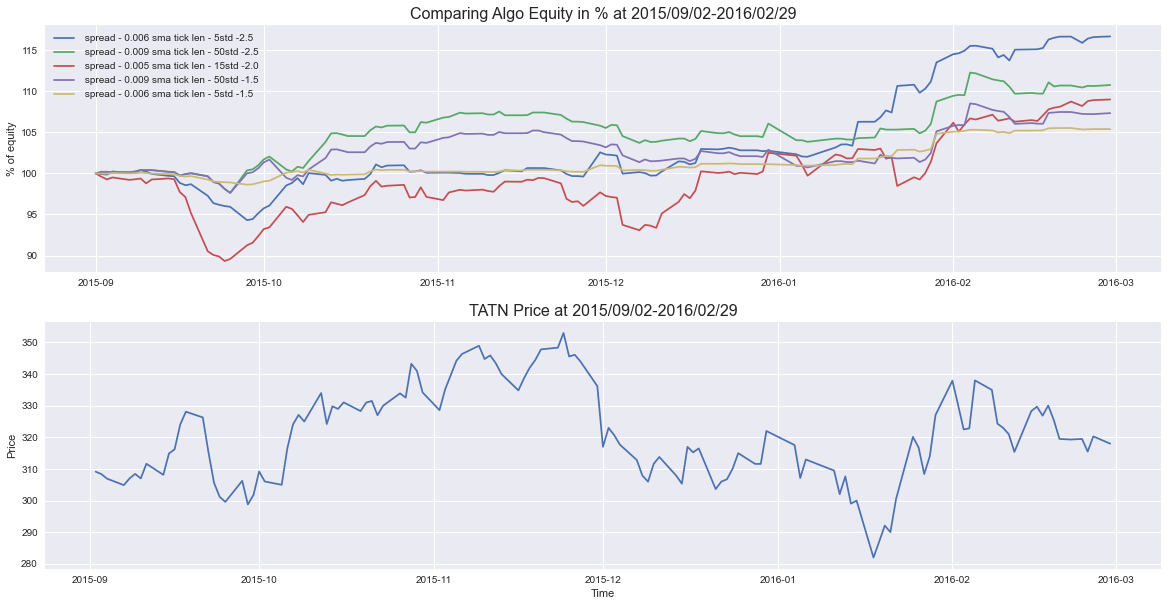

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
spread - 0.006 sma tick len - 5std -2.5,180,500000,51731404,74761,78899,15.78%,2.86%,0.08%,0.17,0.34,2.6,-2.39%,-6.07%,583413,583413,15.78
spread - 0.009 sma tick len - 50std -2.5,180,500000,34605117,49675,52444,10.49%,2.86%,0.06%,0.13,0.25,2.95,-2.28%,-3.55%,553827,561375,10.49
spread - 0.005 sma tick len - 15std -2.0,180,500000,145813921,35058,46724,9.34%,2.86%,0.05%,0.07,0.1,0.88,-5.57%,-10.67%,545028,545028,9.34
spread - 0.009 sma tick len - 50std -1.5,180,500000,35712746,33774,36631,7.33%,2.86%,0.04%,0.1,0.17,1.71,-2.54%,-4.27%,536712,542599,7.33
spread - 0.006 sma tick len - 5std -1.5,180,500000,55912399,101558,106031,5.3%,2.86%,0.03%,0.17,0.44,3.63,-0.6%,-1.46%,527007,527632,5.30


<Figure size 576x396 with 0 Axes>

In [698]:
compare_algo(res_lst, 
             algo_lst, 
             share=share)

In [545]:
start_date = "20150901"
share="LKOH"
enddate = "20160302"
algo_name = "boll"
spread_lst = [i / 1000 for i in range(1, 31)]
tick_lst = [i * 5 for i in range(1, 11)] + [50 + i * 10 for i in range(1, 6)] + [100 + i * 100 for i in range(1, 10)]
std_lst = [i / 10 for i in range(15, 26, 5)]

In [550]:
res_lst = []
algo_lst = []
if share == "LKOH":
    cash = 500000
else:
    cash = 500000
for spread in spread_lst:
    for tick in tick_lst:
        if tick > 199:
            continue
        #if spread == 0.004 and tick == 10:
          #  continue
        if spread != 0.002:
            continue
        if tick != 5 and tick != 25:
            continue

        try:
            if algo_name == "basic":
                res_lst.append(pd.read_csv("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                      " spread - " + str(spread) + " sma tick len - " + str(tick) + ".csv").set_index("Date"))
                algo_lst.append(Basic_MM(cash=cash, name=" spread - " + str(spread) + " sma tick len - " + str(tick)))
               #print("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                #      " spread - " + str(spread) + " sma tick len - " + str(tick) + ".csv")
            elif algo_name == "boll":
                for std in std_lst:
                    if tick == 5 and std == 2.5:
                        continue
                    try:
                        res_lst.append(pd.read_csv("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                              " spread - " + str(spread) + " sma tick len - " + str(tick) + "std -" + str(std) + ".csv").set_index("Date"))

                        algo_lst.append(Bollinger_Bands_MM(cash=cash, name=" spread - " + str(spread) + " sma tick len - " + str(tick) + "std -" + str(std)))
                    except:
                        pass
                    #print("optimizations/" + algo_name + "_res/" + share + "/year" + start_date + '-' + enddate + \
                    #      " spread - " + str(spread) + " sma tick len - " + str(tick) + "std -" + str(std) + ".csv")
        except Exception as e:
            #if tick == 1000 and spread == 0.007:
             #   print(std)
              #  print(e)
            pass
len(res_lst)

5

Stats for date - 20150902 - 20160229


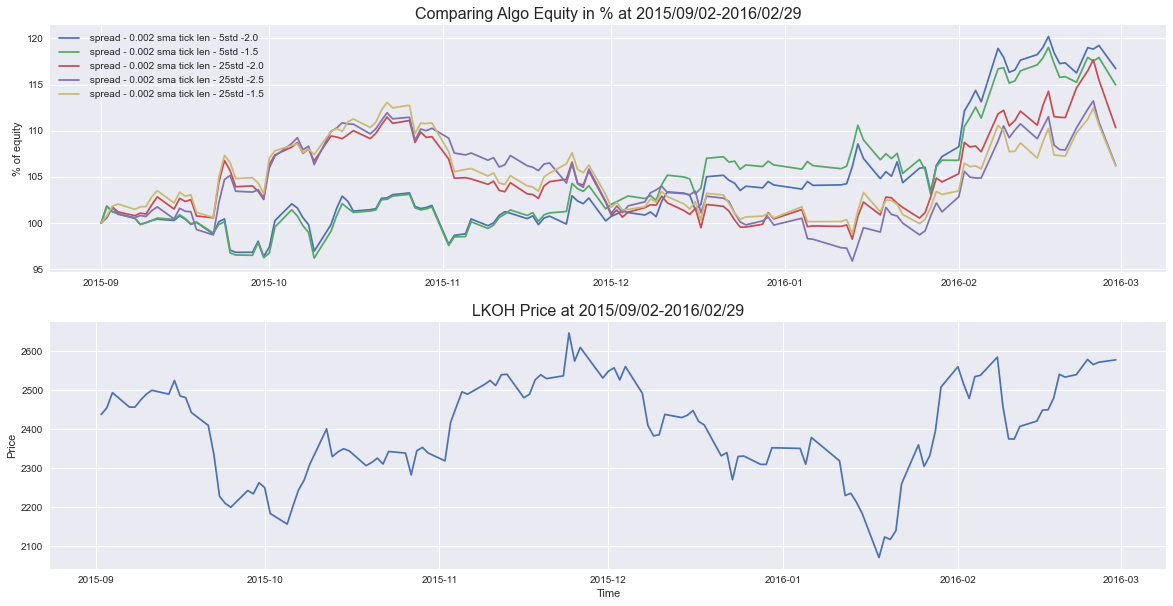

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
spread - 0.002 sma tick len - 5std -2.0,180,500000,920164384,9331,82945,16.59%,5.74%,0.09%,0.1,0.16,3.09,-4.28%,-5.38%,583592,601021,16.59
spread - 0.002 sma tick len - 5std -1.5,180,500000,932253891,576,75156,15.03%,5.74%,0.08%,0.09,0.14,2.21,-4.12%,-6.8%,574768,595131,15.03
spread - 0.002 sma tick len - 25std -2.0,180,500000,1763998267,-86172,54947,10.99%,5.74%,0.06%,0.06,0.1,0.93,-5.03%,-11.85%,551677,588380,10.99
spread - 0.002 sma tick len - 25std -2.5,180,500000,1580316276,-90502,35924,7.18%,5.74%,0.04%,0.04,0.06,0.5,-5.13%,-14.34%,531215,566130,7.18
spread - 0.002 sma tick len - 25std -1.5,180,500000,1895139413,-115962,35649,7.13%,5.74%,0.04%,0.04,0.06,0.57,-4.79%,-12.6%,530770,565331,7.13


<Figure size 576x396 with 0 Axes>

In [551]:
compare_algo(res_lst, 
             algo_lst, 
             share=share)

In [50]:
backtest_year()

TypeError: backtest_year() missing 3 required positional arguments: 'date', 'dom', and 'algo'

In [261]:
year_stats(pd.read_csv("optimizations/basic_res/LKOH/year20150901-20160302 spread - 0.003 sma tick len - 5.csv").set_index("Date"), Basic_MM())

KeyError: "None of ['Date'] are in the columns"

In [60]:
tmp_res = pd.read_csv("optimizations/basic_res/LKOH/year20150901-20160302 spread - 0.003 sma tick len - 5.csv").set_index("Date")

# Научимся считывать данные по сложному алгоритму  

Stats for date - 20150302 - 20150902
Algo Info: 

Algo name - Hard Correlation MM
Hyperparams - 
                 LKOH     TATN
B                   2        2
spread_max    51.0935  5.51267
spread_min    21.0385  2.26992
volume             30      100
q_max             457     4240
first_price      3010      319
basic_volume       33      308
MA_type           WMA      WMA
tick                5       15

Correlation matrix
     LKOH TATN
LKOH  1.0  0.7
TATN  0.7  1.0

Speed of orders - 3ms.



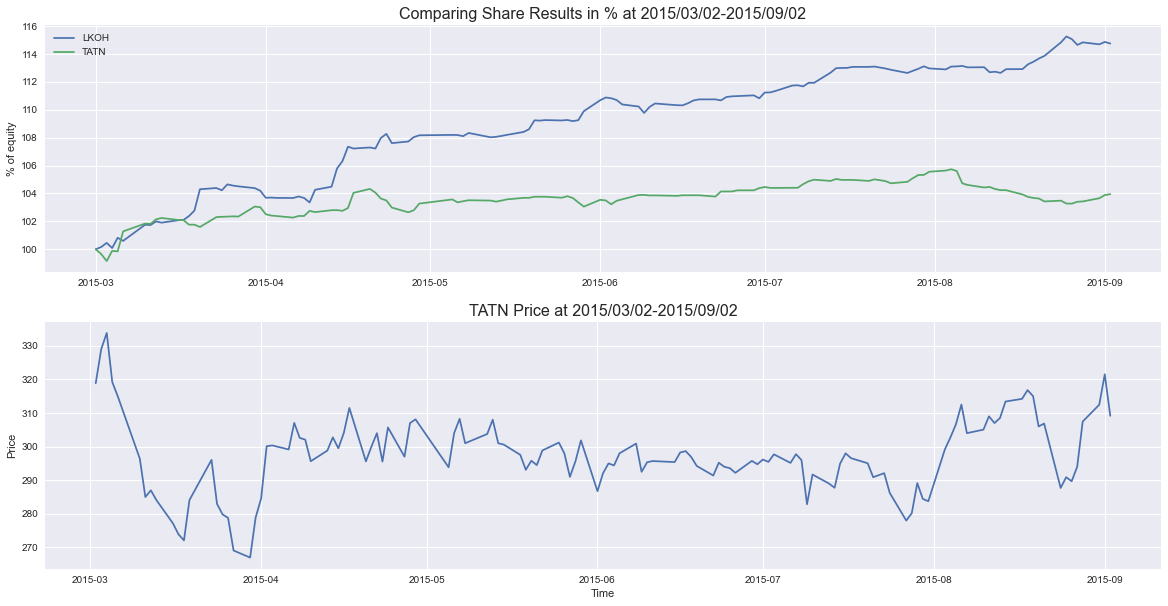

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak
LKOH,184,1000000,137309349,58186,69170,13.83%,-18.43%,0.07%,1.33,inf,11.19,-0.65%,-1.24%,1147536,1152611
TATN,184,1000000,26983093,17462,19621,3.92%,-3.04%,0.02%,0.38,0.81,1.68,-1.14%,-2.33%,1039529,1057369


<Figure size 576x396 with 0 Axes>

In [160]:
import json

path = "optimizations/hard_res/LKOH TATNcash500000/WMASMAtanh5-10/y-20150301-20150902LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max29133TATN,spr=0.005-0.007B-2,q_max2698,basvol - 308.csv"
share_lst = pd.read_csv(path).columns[1:]
res_corr = []

for share in share_lst:
    tmp = list(pd.read_csv(path)[share])
    res_share = []
    for day_st in tmp:
        res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
    res_corr.append(pd.DataFrame(res_share).set_index("Date"))

multystock_stat(res_corr, Hard_Correlation_MM(hyperparams, corr_matrix), list(share_lst))

In [146]:
pd.read_csv(path)

,Unnamed: 0


In [20]:
latency = 3
date = '20150303'
hyperparams = dict()
share_lst = ['GAZP','SBER','AFKS','LKOH', 'SNGS', 'HYDR', 'TATN', 'SNGSP',
             'ROSN','RTKM','URKA','GMKN', 'MTSS', 'FEES', 'NLMK', 'MGNT',
             'CHMF', 'VTBR', 'SBERP', 'ALRS', 'MAGN', 'MOEX', 'NVTK',
             'TATNP', 'IRAO', 'AKRN', 'PIKK', 'POLY', 'LSRG', 'MTLR']
price_step = {'GAZP': .01,'SBER': .01,'AFKS': .001,'LKOH': .1, 'SNGS': .05, 'HYDR': .0001, 'TATN': .1, 'SNGSP': .005,
             'ROSN': .05,'RTKM': .01,'URKA': .01,'GMKN': 2, 'MTSS': .05, 'FEES': .00002, 'NLMK': .02, 'MGNT': .5,
             'CHMF': .2, 'VTBR': .000005, 'SBERP': .01, 'ALRS': .01, 'MAGN': .005, 'MOEX': .01, 'NVTK': .2,
             'TATN|P': .1, 'IRAO': .2, 'AKRN': 2, 'PIKK': .1, 'POLY': .1, 'LSRG': .2, 'MTLR': .01}
lot_size = {'GAZP': 10,'SBER': 10,'AFKS': 100,'LKOH': 1, 'SNGS': 100, 'HYDR': 10, 'TATN': 1, 'SNGSP': 100,
            'ROSN': 10,'RTKM': 10,'URKA': 10,'GMKN': 1, 'MTSS': 10, 'FEES': 10000, 'NLMK': 10, 'MGNT': 10,
            'CHMF': 1, 'VTBR': 10000, 'SBERP': 10, 'ALRS': 10, 'MAGN': 1, 'MOEX': 10, 'NVTK': 1,
            'TATNP': 1, 'IRAO': 1000, 'AKRN': 1, 'PIKK': 10, 'POLY': 1, 'LSRG': 1, 'MTLR': 1}

#hard model params

share_corr = ["LKOH", "TATN"]
hyperparams[share_corr[0]], hyperparams[share_corr[1]] = dict(), dict()
corr_matrix = [[1.0, 0.7], [0.7, 1.0]]
nocorr_matrix = [[1.0, 0.0], [0.0, 1.0]]

hyperparams[share_corr[0]]["B"] = 2
hyperparams[share_corr[0]]["spread_max"] = 10
hyperparams[share_corr[0]]["spread_min"] = 5
hyperparams[share_corr[0]]["volume"] = 30
hyperparams[share_corr[0]]["q_max"] = 200
hyperparams[share_corr[0]]["first_price"] = 3010

hyperparams[share_corr[1]]["B"] = 2
hyperparams[share_corr[1]]["spread_max"] = 5
hyperparams[share_corr[1]]["spread_min"] = 2
hyperparams[share_corr[1]]["volume"] = 100
hyperparams[share_corr[1]]["q_max"] = 2000
hyperparams[share_corr[1]]["first_price"] = 319

In [46]:
#pd.read_csv("optimizations/hard_res/LKOH TATN/SMAtanh20/y-20150301-20150902LKOHspr=0.0015-0.0115B-2q_max190TATNspr=0.004-0.006B-2q_max1657.csv")

In [68]:
def hard_res_compare(overall_res, models, shares=share_corr):
    portfolio_res = deepcopy(overall_res[0])
    new_models = deepcopy(models)
    for share in range(1, len(share_corr)):
        for i in range(len(overall_res[0])):
            try:
                portfolio_res[i] = portfolio_res[i][~portfolio_res[i].index.duplicated()] + \
                overall_res[share][i][~overall_res[share][i].index.duplicated()] # df = df[~df.index.duplicated()]
                portfolio_res[i]["Total_Return"] = portfolio_res[i]["Total_Return"] / 2
                portfolio_res[i]["Max_day_drawdown"] = portfolio_res[i]["Max_day_drawdown"] / 2
                #TODO тут костыль на кеш
                new_models[i].in_cash_change(10000000 * len(share_corr))
            except Exception as e:
                portfolio_res[i]["Total_Return"] = portfolio_res[i]["Total_Return"] / 2
                portfolio_res[i]["Max_day_drawdown"] = portfolio_res[i]["Max_day_drawdown"] / 2
               # new_models[i].in_cash_change(500000 * len(share_corr))
                print("problem at", i, ". - ", e)
                #raise Exception
            
    print(compare_algo(portfolio_res, 
                       new_models, 
                       share="Portfolio"))
    for share in range(len(share_corr)):
        print(compare_algo(overall_res[share], 
              models, 
              share=share_corr[share]))
    
    
    

In [141]:
#overall_res[0][0] + overall_res[1][0]

#  Тоже самое но с разными MA

## не забудь поменть путь для объемов и вообще название в таблицах

In [64]:
from random import sample

start_date = "20150301"
enddate = "20150902"
date = "20150302"
corr_path = "hard_res"
share_corr = ["GAZP", "SBER"]


if platform.system() == "Darwin":
    fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/OrderLog" + date + ".txt", sep=',')
else:
    fol = pd.read_csv("//TKSSS-MVP000104/Data/OrderLog" + date + "/OrderLog" + date + ".txt", sep=',')
share_lst = ['GAZP','SBER','AFKS','LKOH', 'SNGS', 'HYDR', 'TATN', 'SNGSP',
             'ROSN','RTKM','URKA','GMKN', 'MTSS', 'FEES', 'NLMK', 'MGNT',
             'CHMF', 'VTBR', 'SBERP', 'ALRS', 'MAGN', 'MOEX', 'NVTK',
             'TATNP', 'IRAO', 'AKRN', 'PIKK', 'POLY', 'LSRG', 'MTLR']
show_graph = False
params = dict()
spread_lst = [0.002, 0.0025, 0.003, 0.004, 0.005, 0.006, 0.007]
lkoh_spread_lst = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.035, 0.005, 0.006, 0.008, 0.01, 0.012, 0.015, 0.018]
tatn_spread_lst = lkoh_spread_lst
tick_lst = [3, 5, 7, 10, 15, 20, 30, 50, 100, 200]
cash_volume = 1000000
params["cash"] = 10000000

print("Actual share is -", share_corr)
print("If you want to change corr or shares, go to config default")

print(*share_corr, "dir exist")

hyperparams = {share_corr[0]: dict(), share_corr[1]: dict()}
for share in share_corr:
    share_logs = fol[fol["SECCODE"] == share]
    hyperparams[share]["basic_volume"] = max(myround(cash_volume // median(list(share_logs["PRICE"])[100:200]), base=lot_size[share]), 1)
    hyperparams[share]["first_price"] = median(list(share_logs["PRICE"])[100:200])
    hyperparams[share]["volume"] = hyperparams[share]["basic_volume"] 
#params["cash"] = 500000
params["price_step"] = price_step
params["num_of_shares"] = len(share_corr)
overall_res = [None] * len(share_corr)
models = []
num = 0
alter_num = 0
share_logs = fol[fol["SECCODE"] == share_corr[0]]
share_logs_2 = fol[fol["SECCODE"] == share_corr[1]]
price_fst = median(list(share_logs["PRICE"])[100:200])
price_sec = median(list(share_logs_2["PRICE"])[100:200])
del fol, share_logs, share_logs_2

for sigmoid_type in sample(["tanh", "gauss", "arctan"], 3):
    for tick in sample(tick_lst, len(tick_lst)):
        for tick_2 in sample(tick_lst, len(tick_lst)):
            for sma_type_1 in sample(["SMA", "EMA", "WMA", "EMA2"], 4):
                for sma_type_2 in sample(["EMA", "SMA", "WMA", "EMA2"], 4):
                    if tick == tick_2:
                        tick_info = str(tick)
                    else:
                        tick_info = str(tick) + '-' + str(tick_2)
                    if platform.system() != "Darwin":
                        if os.path.isdir("//TKSSS-MVP000104/" + corr_path + '/' + " ".join(
                                share_corr) + "\\" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info):
                            print(" ".join(share_corr) + "cash" + str(params["cash"]) + "\\" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info, "dir exist")
                        else:
                            continue

                    else:
                        if os.path.isdir("optimizations/" + corr_path + '/' + " ".join(
                                share_corr) + "cash" + str(params["cash"]) + "/" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info):
                            print(" ".join(share_corr)  + "cash" + str(params["cash"]) + "/" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info, "dir exist")
                        else:
                            #print("optimizations/" + corr_path + '/' + " ".join(
                             #   share_corr) + "cash" + str(params["cash"]) + "/" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info)
                            #raise Exception
                            continue

    
                #TODO more than 2 stock
                    for spread_min in sample(lkoh_spread_lst, len(lkoh_spread_lst)):
                        for spread_max_delta in sample([0.002, 0.005, 0.01], 3):
                            for q_max_cash in sample([0.5, 0.75, 1.75, 2.25], 4):
                                for B in sample([2, 10], 2):

                                    for spread_min_2 in sample(tatn_spread_lst, len(tatn_spread_lst)):
                                        for spread_max_delta_2 in sample([0.002, 0.005, 0.01], 3):
                                            for B_2 in sample([2, 10], 2):


                                                hyperparams[share_corr[0]]['spread_min'] = spread_min * price_fst
                                                hyperparams[share_corr[0]]['spread_max'] = (spread_min + spread_max_delta) * price_fst
                                                hyperparams[share_corr[0]]['B'] = B
                                                hyperparams[share_corr[0]]['q_max'] = max(myround(params["cash"] * q_max_cash // price_fst,
                                                                                                 base=lot_size[share_corr[0]]), 1)
                                                hyperparams[share_corr[0]]["MA_type"] = sma_type_1
                                                hyperparams[share_corr[0]]["tick"] = tick

                                                hyperparams[share_corr[1]]['spread_min'] = spread_min_2 * price_sec
                                                hyperparams[share_corr[1]]['spread_max'] = (spread_min_2 + spread_max_delta_2) * price_sec
                                                hyperparams[share_corr[1]]['B'] = B_2
                                                hyperparams[share_corr[1]]['q_max'] = max(myround(
                                                params["cash"] * q_max_cash // price_sec,
                                                    base=lot_size[share_corr[1]]), 1)
                                                hyperparams[share_corr[1]]["MA_type"] = sma_type_2
                                                hyperparams[share_corr[1]]["tick"] = tick_2
                                            #sma_type="SMA"


                                                if platform.system() == "Darwin":

                                                    path = "optimizations/" + corr_path + '/' + " ".join(share_corr) + "cash" + str(params["cash"]) + "/" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info \
                                                            + "/y-" + start_date + '-' + enddate + share_corr[0] + \
                                                            'spr=' + str(spread_min) + '-' + str(spread_min + spread_max_delta) \
                                                            + 'B-' + str(B) + 'q_max' + str(hyperparams[share_corr[0]]['q_max']) +\
                                                            share_corr[1] + 'spr=' + str(spread_min_2) + '-' + str(spread_min_2 + spread_max_delta_2) \
                                                            + 'B-' + str(B_2) + 'q_max' + str(hyperparams[share_corr[1]]['q_max']) +\
                                                            ".csv"
                                                    alter_path = "optimizations/" + corr_path + '/' + " ".join(share_corr) + "cash" + str(params["cash"]) + "/" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info \
                                                            + "/y-" + start_date + '-' + enddate + share_corr[0] + \
                                                            ',spr=' + str(spread_min) + '-' + str(spread_min + spread_max_delta) \
                                                            + ',B-' + str(B) + ',q_max' + str(hyperparams[share_corr[0]]['q_max']) +str(
                                                        hyperparams[share_corr[0]]['basic_volume']) +\
                                                            share_corr[1] + ',spr=' + str(spread_min_2) + '-' + str(spread_min_2 + spread_max_delta_2) \
                                                            + 'B-' + str(B_2) + ',q_max' + str(hyperparams[share_corr[1]]['q_max']) + ",basvol - " + str(
                                                        hyperparams[share_corr[1]]['basic_volume']) +\
                                                            ".csv"
                                                    name = share_corr[0] + ": " + sma_type_1  + ", " + str(tick) + ", " + sigmoid_type \
                                                            + ' ,spr=' + str(spread_min) + '-' + str(round(spread_min + spread_max_delta, 5)) \
                                                            + ' ,B-' + str(B) + ' ,q_max' + str(hyperparams[share_corr[0]]['q_max']) +\
                                                            '   ' + share_corr[1] + ": " + sma_type_2  + " ," + str(tick_2) + " ," + sigmoid_type + \
                                                            ' ,spr=' + str(spread_min_2) + '-' + str(round(spread_min_2 + spread_max_delta_2, 5)) \
                                                            + ' ,B-' + str(B_2) + ' ,q_max' + str(hyperparams[share_corr[1]]['q_max'])# +  " ,date-" + str(start_date) + '-' + str(enddate) + '\n'
                                                else:
                                                    path = "//TKSSS-MVP000104/" + corr_path + '/' + " ".join(share_corr)\
                                                           + "/" + sma_type_1 + sma_type_2 + sigmoid_type + tick_info \
                                                           + "/y-" + start_date + '-' + enddate + share_corr[0] + \
                                                           'spr=' + str(spread_min) + '-' + str(
                                                        spread_min + spread_max_delta) \
                                                           + 'B-' + str(B) + 'q_max' + str(
                                                        hyperparams[share_corr[0]]['q_max']) + \
                                                           share_corr[1] + 'spr=' + str(spread_min_2) + '-' + str(
                                                        spread_min_2 + spread_max_delta_2) \
                                                           + 'B-' + str(B_2) + 'q_max' + str(
                                                        hyperparams[share_corr[1]]['q_max']) + \
                                                           ".csv"
                                                    name = path
                                                    
                                                try:
                                                    #raise Exception
                                                    file = pd.read_csv(path)
                                                    #print("find", path)
                                                    #if overall_res[0]:
                                                     #   print(len(models), len(overall_res[0]))
                                                    num += 1
                                                except Exception as e:
                                                    try:
                                                        #print(alter_path)
                                                        file = pd.read_csv(alter_path)
                                                        path = alter_path
                                                        #name += ",basvol - " + str(hyperparams[share_corr[1]]['basic_volume'])
                                                        alter_num += 1
                                                    #print(e)
                                                    except:
                                                        #print(alter_path)
                                                        #raise Exception
                                                        continue

                                                #res_corr = []

                                                try:
                                                    for share in range(len(share_corr)):
                                                        tmp = list(file[share_corr[share]])
                                                        res_share = []
                                                        for day_st in tmp:
                                                            res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
                                                        if overall_res[share]:
                                                            overall_res[share].append(pd.DataFrame(res_share).set_index("Date").drop_duplicates())
                                                        else:
                                                            overall_res[share] = [pd.DataFrame(res_share).set_index("Date")]
                                                except Exception as e:
                                                    if str(e) != "'GAZP'":
                                                        out = e

                                                        print("find strange path ", path, "\n exception - ", e)
                                                        #raise Exception
                                                    continue

                                                #multystock_stat(res_corr, Hard_Correlation_MM(hyperparams, corr_matrix), list(share_corr))
                                                #overall_res.append(res_corr)
                                                models.append(Hard_Correlation_MM(hyperparams, corr_matrix, name=name, cash=params["cash"]))
                                                #raise Exception

Actual share is - ['GAZP', 'SBER']
If you want to change corr or shares, go to config default
GAZP SBER dir exist
GAZP SBERcash10000000/EMA2SMAarctan30-10 dir exist
GAZP SBERcash10000000/EMA2WMAarctan30-10 dir exist
GAZP SBERcash10000000/EMA2EMA2arctan30-10 dir exist
GAZP SBERcash10000000/SMAWMAarctan30-10 dir exist
GAZP SBERcash10000000/SMAEMA2arctan30-10 dir exist
GAZP SBERcash10000000/SMASMAarctan30-10 dir exist
GAZP SBERcash10000000/WMAEMA2arctan30-10 dir exist
GAZP SBERcash10000000/WMAWMAarctan30-10 dir exist
GAZP SBERcash10000000/EMA2WMAarctan30 dir exist
GAZP SBERcash10000000/EMA2SMAarctan30 dir exist
GAZP SBERcash10000000/EMA2EMA2arctan30 dir exist
GAZP SBERcash10000000/WMAEMA2arctan30 dir exist
GAZP SBERcash10000000/WMASMAarctan30 dir exist
GAZP SBERcash10000000/SMASMAarctan30 dir exist
GAZP SBERcash10000000/SMAWMAarctan30 dir exist
GAZP SBERcash10000000/SMAEMA2arctan30 dir exist
GAZP SBERcash10000000/EMASMAarctan30-100 dir exist
GAZP SBERcash10000000/WMAWMAarctan30-100 dir ex

GAZP SBERcash10000000/EMA2SMAarctan3-5 dir exist
GAZP SBERcash10000000/WMAEMA2arctan3-5 dir exist
GAZP SBERcash10000000/WMAWMAarctan3-5 dir exist
GAZP SBERcash10000000/WMASMAarctan3-15 dir exist
GAZP SBERcash10000000/SMASMAarctan3-15 dir exist
GAZP SBERcash10000000/SMAWMAarctan3-15 dir exist
GAZP SBERcash10000000/EMA2SMAarctan3-15 dir exist
GAZP SBERcash10000000/EMA2WMAarctan3-15 dir exist
GAZP SBERcash10000000/WMASMAarctan3-20 dir exist
GAZP SBERcash10000000/WMAWMAarctan3-20 dir exist
GAZP SBERcash10000000/SMASMAarctan3-20 dir exist
GAZP SBERcash10000000/EMA2EMA2arctan3-20 dir exist
GAZP SBERcash10000000/SMASMAarctan3-30 dir exist
GAZP SBERcash10000000/SMAEMA2arctan3-30 dir exist
GAZP SBERcash10000000/SMAWMAarctan3-30 dir exist
GAZP SBERcash10000000/WMAEMA2arctan3-30 dir exist
GAZP SBERcash10000000/WMASMAarctan3-30 dir exist
GAZP SBERcash10000000/WMAWMAarctan3-30 dir exist
GAZP SBERcash10000000/WMAEMA2arctan3-7 dir exist
GAZP SBERcash10000000/WMAWMAarctan3-7 dir exist
GAZP SBERcash100

GAZP SBERcash10000000/EMA2WMAarctan10-30 dir exist
GAZP SBERcash10000000/EMA2SMAarctan10-30 dir exist
GAZP SBERcash10000000/EMA2EMA2arctan10-30 dir exist
GAZP SBERcash10000000/EMA2WMAarctan10 dir exist
GAZP SBERcash10000000/EMA2EMA2arctan10 dir exist
GAZP SBERcash10000000/WMAWMAarctan10 dir exist
GAZP SBERcash10000000/WMAEMAarctan10 dir exist
GAZP SBERcash10000000/SMAEMAarctan10-15 dir exist
GAZP SBERcash10000000/SMAEMA2arctan10-15 dir exist
GAZP SBERcash10000000/SMASMAarctan10-15 dir exist
GAZP SBERcash10000000/EMA2WMAarctan10-15 dir exist
GAZP SBERcash10000000/EMA2SMAarctan10-15 dir exist
GAZP SBERcash10000000/WMASMAarctan10-15 dir exist
GAZP SBERcash10000000/WMAEMA2arctan10-15 dir exist
GAZP SBERcash10000000/WMAEMAarctan10-15 dir exist
GAZP SBERcash10000000/EMAEMAarctan10-15 dir exist
GAZP SBERcash10000000/EMASMAarctan10-200 dir exist
GAZP SBERcash10000000/SMAEMAarctan10-200 dir exist
GAZP SBERcash10000000/SMASMAarctan20 dir exist
GAZP SBERcash10000000/SMAEMAarctan20 dir exist
GAZP 

GAZP SBERcash10000000/SMASMAtanh30-5 dir exist
GAZP SBERcash10000000/SMAEMA2tanh30-5 dir exist
GAZP SBERcash10000000/WMAEMA2tanh30-5 dir exist
GAZP SBERcash10000000/WMASMAtanh30-5 dir exist
GAZP SBERcash10000000/EMASMAtanh30-5 dir exist
GAZP SBERcash10000000/WMASMAtanh30 dir exist
GAZP SBERcash10000000/WMAWMAtanh30 dir exist
GAZP SBERcash10000000/SMAWMAtanh30 dir exist
GAZP SBERcash10000000/SMAEMA2tanh30 dir exist
GAZP SBERcash10000000/EMA2SMAtanh30 dir exist
GAZP SBERcash10000000/EMA2WMAtanh30 dir exist
GAZP SBERcash10000000/WMASMAtanh30-200 dir exist
GAZP SBERcash10000000/EMA2EMA2tanh30-200 dir exist
GAZP SBERcash10000000/WMAEMAtanh30-100 dir exist
GAZP SBERcash10000000/WMAWMAtanh30-100 dir exist
GAZP SBERcash10000000/SMASMAtanh30-100 dir exist
GAZP SBERcash10000000/WMAEMA2tanh30-15 dir exist
GAZP SBERcash10000000/SMASMAtanh30-15 dir exist
GAZP SBERcash10000000/EMA2SMAtanh30-15 dir exist
GAZP SBERcash10000000/EMA2WMAtanh30-15 dir exist
GAZP SBERcash10000000/EMA2EMA2tanh30-15 dir exis

GAZP SBERcash10000000/EMA2EMA2tanh5 dir exist
GAZP SBERcash10000000/EMA2SMAtanh5 dir exist
GAZP SBERcash10000000/EMA2WMAtanh5 dir exist
GAZP SBERcash10000000/SMASMAtanh5-15 dir exist
GAZP SBERcash10000000/SMAWMAtanh5-15 dir exist
GAZP SBERcash10000000/SMAEMA2tanh5-15 dir exist
GAZP SBERcash10000000/EMA2SMAtanh5-15 dir exist
GAZP SBERcash10000000/SMAWMAtanh5-20 dir exist
GAZP SBERcash10000000/EMA2WMAtanh5-20 dir exist
GAZP SBERcash10000000/EMA2EMA2tanh5-20 dir exist
GAZP SBERcash10000000/EMA2SMAtanh5-20 dir exist
GAZP SBERcash10000000/WMAWMAtanh5-20 dir exist
GAZP SBERcash10000000/WMAEMA2tanh5-20 dir exist
GAZP SBERcash10000000/WMASMAtanh5-20 dir exist
GAZP SBERcash10000000/EMAEMAtanh5-30 dir exist
GAZP SBERcash10000000/SMAEMA2tanh5-30 dir exist
GAZP SBERcash10000000/SMASMAtanh5-30 dir exist
GAZP SBERcash10000000/SMAWMAtanh5-30 dir exist
GAZP SBERcash10000000/WMASMAtanh5-30 dir exist
GAZP SBERcash10000000/WMAWMAtanh5-30 dir exist
GAZP SBERcash10000000/EMA2WMAtanh5-30 dir exist
GAZP SBER

GAZP SBERcash10000000/SMASMAgauss20-3 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss20-3 dir exist
GAZP SBERcash10000000/EMA2WMAgauss20-3 dir exist
GAZP SBERcash10000000/EMA2SMAgauss20-3 dir exist
GAZP SBERcash10000000/EMA2SMAgauss20 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss20 dir exist
GAZP SBERcash10000000/SMAEMAgauss20 dir exist
GAZP SBERcash10000000/SMAEMA2gauss20 dir exist
GAZP SBERcash10000000/SMASMAgauss20 dir exist
GAZP SBERcash10000000/SMAWMAgauss20 dir exist
GAZP SBERcash10000000/WMASMAgauss20 dir exist
GAZP SBERcash10000000/WMAWMAgauss20 dir exist
GAZP SBERcash10000000/WMAEMA2gauss20 dir exist
GAZP SBERcash10000000/SMAEMA2gauss20-10 dir exist
GAZP SBERcash10000000/SMASMAgauss20-10 dir exist
GAZP SBERcash10000000/WMAWMAgauss20-10 dir exist
GAZP SBERcash10000000/SMAWMAgauss20-100 dir exist
GAZP SBERcash10000000/EMASMAgauss20-100 dir exist
GAZP SBERcash10000000/EMAEMAgauss20-100 dir exist
GAZP SBERcash10000000/SMAWMAgauss20-7 dir exist
GAZP SBERcash10000000/SMAEMA2gauss20-7 

GAZP SBERcash10000000/WMASMAgauss10-15 dir exist
GAZP SBERcash10000000/WMAEMA2gauss10-15 dir exist
GAZP SBERcash10000000/WMASMAgauss10-100 dir exist
GAZP SBERcash10000000/SMAWMAgauss10-3 dir exist
GAZP SBERcash10000000/WMAWMAgauss10-3 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss10-3 dir exist
GAZP SBERcash10000000/SMASMAgauss10-50 dir exist
GAZP SBERcash10000000/SMAWMAgauss10-50 dir exist
GAZP SBERcash10000000/EMA2WMAgauss10-50 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss10-50 dir exist
GAZP SBERcash10000000/WMAWMAgauss10-50 dir exist
GAZP SBERcash10000000/WMAEMA2gauss10-50 dir exist
GAZP SBERcash10000000/WMASMAgauss10-50 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss10 dir exist
GAZP SBERcash10000000/SMASMAgauss10 dir exist
GAZP SBERcash10000000/WMAEMA2gauss10 dir exist
GAZP SBERcash10000000/WMAWMAgauss10-5 dir exist
GAZP SBERcash10000000/WMAEMA2gauss10-5 dir exist
GAZP SBERcash10000000/SMAWMAgauss10-5 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss10-5 dir exist
GAZP SBERcash10000000/

GAZP SBERcash10000000/EMA2EMA2gauss3-10 dir exist
GAZP SBERcash10000000/EMA2WMAgauss3-10 dir exist
GAZP SBERcash10000000/EMA2SMAgauss3-10 dir exist
GAZP SBERcash10000000/SMAWMAgauss3-10 dir exist
GAZP SBERcash10000000/SMAWMAgauss3-30 dir exist
GAZP SBERcash10000000/SMAEMA2gauss3-30 dir exist
GAZP SBERcash10000000/EMA2SMAgauss3-30 dir exist
GAZP SBERcash10000000/EMA2WMAgauss3-30 dir exist
GAZP SBERcash10000000/EMA2WMAgauss7-3 dir exist
GAZP SBERcash10000000/EMA2EMA2gauss7-3 dir exist
GAZP SBERcash10000000/SMAWMAgauss7-3 dir exist
GAZP SBERcash10000000/SMASMAgauss7-3 dir exist
GAZP SBERcash10000000/WMASMAgauss7-3 dir exist
GAZP SBERcash10000000/WMAEMA2gauss7-3 dir exist
GAZP SBERcash10000000/SMASMAgauss7-15 dir exist
GAZP SBERcash10000000/SMAEMA2gauss7-15 dir exist
GAZP SBERcash10000000/SMAWMAgauss7-15 dir exist
GAZP SBERcash10000000/WMAWMAgauss7-15 dir exist
GAZP SBERcash10000000/WMASMAgauss7-15 dir exist
GAZP SBERcash10000000/EMA2SMAgauss7-15 dir exist
GAZP SBERcash10000000/EMA2WMAgaus

In [65]:
num, alter_num, alter_path

(0,
 6671,
 'optimizations/hard_res/GAZP SBERcash10000000/EMA2WMAgauss7-30/y-20150301-20150902GAZP,spr=0.015-0.02,B-10,q_max1460806490SBER,spr=0.018-0.023B-2,q_max292890,basvol - 13020.csv')

In [66]:
#for i in range(len(overall_res[1])):
len(overall_res[1]) #5820

6139

Stats for date - 20150302 - 20150902


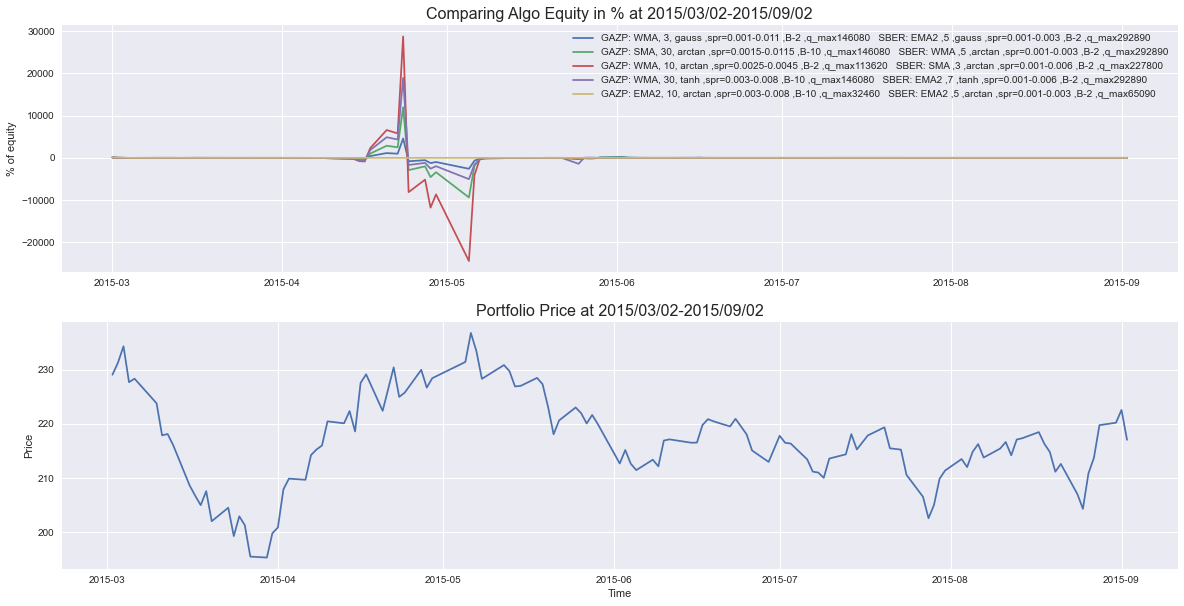

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
"GAZP: WMA, 3, gauss ,spr=0.001-0.011 ,B-2 ,q_max146080 SBER: EMA2 ,5 ,gauss ,spr=0.001-0.003 ,B-2 ,q_max292890",184,20000000,1095102039655,948602965,1036211129,5181.06%,-5.24%,2.18%,0.09,0.49,0.00,-2.56%,-2370356.39%,-949,917168411,5181.06
"GAZP: SMA, 30, arctan ,spr=0.0015-0.0115 ,B-10 ,q_max146080 SBER: WMA ,5 ,arctan ,spr=0.001-0.003 ,B-2 ,q_max292890",184,20000000,1120912953624,938138429,1027811465,5139.06%,-5.24%,2.17%,0.09,0.45,0.00,-2.29%,-11508625.53%,6824,2395395938,5139.06
"GAZP: WMA, 10, arctan ,spr=0.0025-0.0045 ,B-2 ,q_max113620 SBER: SMA ,3 ,arctan ,spr=0.001-0.006 ,B-2 ,q_max227800",184,20000000,1090964171929,822985826,910262960,4551.31%,-5.24%,2.11%,0.09,0.39,0.00,-2.33%,-11455148.75%,-407,5750572505,4551.31
"GAZP: WMA, 30, tanh ,spr=0.003-0.008 ,B-10 ,q_max146080 SBER: EMA2 ,7 ,tanh ,spr=0.001-0.006 ,B-2 ,q_max292890",184,20000000,982619787104,598551226,677160809,3385.8%,-5.24%,1.95%,0.09,0.33,0.00,-2.12%,-1076171.7%,-124,3788153682,3385.80
"GAZP: EMA2, 10, arctan ,spr=0.003-0.008 ,B-10 ,q_max32460 SBER: EMA2 ,5 ,arctan ,spr=0.001-0.003 ,B-2 ,q_max65090",184,20000000,751919802635,595330232,655483816,3277.42%,-5.24%,1.93%,0.09,0.45,0.01,-1.68%,-427042.2%,-2,20000000,3277.42
"GAZP: WMA, 7, tanh ,spr=0.0025-0.0125 ,B-10 ,q_max146080 SBER: WMA ,10 ,tanh ,spr=0.001-0.003 ,B-2 ,q_max292890",184,20000000,924175929593,541192235,615126310,3075.63%,-5.24%,1.9%,0.09,0.32,0.06,-2.16%,-48278.11%,-1,613877939,3075.63
"GAZP: SMA, 20, tanh ,spr=0.0015-0.0065 ,B-2 ,q_max32460 SBER: WMA ,3 ,tanh ,spr=0.001-0.006 ,B-2 ,q_max65090",184,20000000,758129211304,506524443,567174780,2835.87%,-5.24%,1.85%,0.09,0.37,0.01,-1.96%,-439440.23%,-13,20000000,2835.87
"GAZP: WMA, 7, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max146080 SBER: WMA ,50 ,tanh ,spr=0.001-0.003 ,B-2 ,q_max292890",184,20000000,577631323756,484485886,530696392,2653.48%,-5.24%,1.82%,0.09,0.53,0.02,-1.88%,-165634.52%,-16,20000000,2653.48
"GAZP: SMA, 10, tanh ,spr=0.003-0.005 ,B-2 ,q_max113620 SBER: EMA2 ,50 ,tanh ,spr=0.001-0.006 ,B-2 ,q_max227800",184,20000000,487341911314,431919306,470906659,2354.53%,-5.24%,1.75%,0.09,0.60,0.58,-1.87%,-4041.39%,155,20000000,2354.53
"GAZP: WMA, 5, arctan ,spr=0.003-0.013 ,B-2 ,q_max146080 SBER: EMA2 ,20 ,arctan ,spr=0.001-0.003 ,B-2 ,q_max292890",184,20000000,757701493206,398523260,459139379,2295.7%,-5.24%,1.74%,0.09,0.29,0.00,-2.04%,-795622.21%,277,20000000,2295.70


None
Stats for date - 20150302 - 20150902


<Figure size 576x396 with 0 Axes>

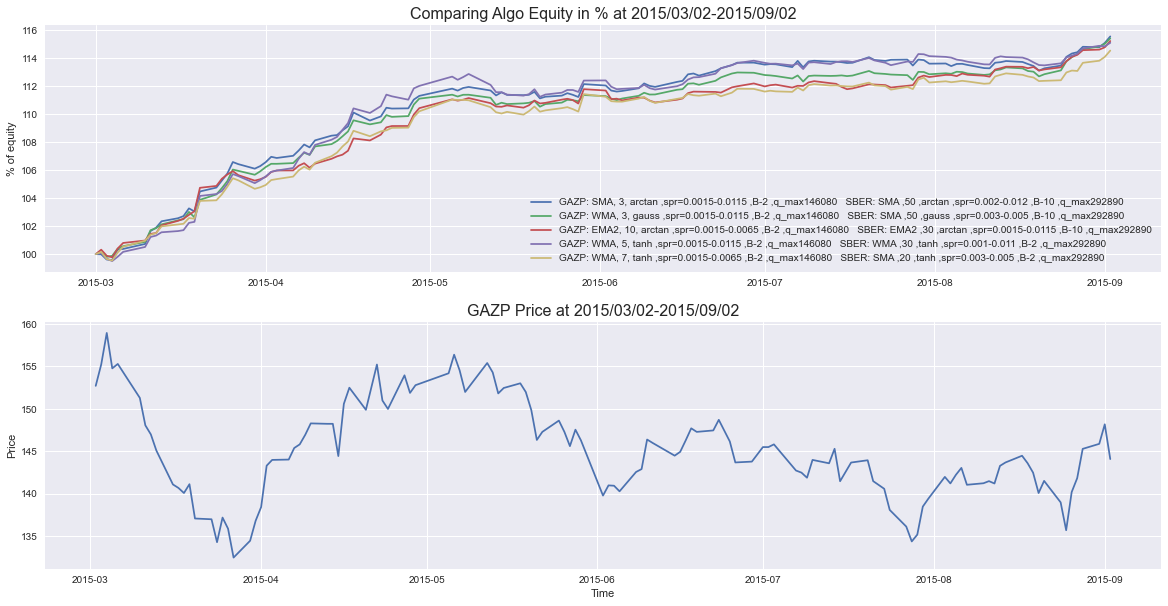

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
"GAZP: SMA, 3, arctan ,spr=0.0015-0.0115 ,B-2 ,q_max146080 SBER: SMA ,50 ,arctan ,spr=0.002-0.012 ,B-10 ,q_max292890",184,10000000,7893700848,822002,1453498,14.53%,-5.64%,0.07%,0.39,0.98,17.23,-0.77%,-0.84%,11557103,11557103,14.53
"GAZP: WMA, 3, gauss ,spr=0.0015-0.0115 ,B-2 ,q_max146080 SBER: SMA ,50 ,gauss ,spr=0.003-0.005 ,B-10 ,q_max292890",184,10000000,7941426357,804967,1440281,14.4%,-5.64%,0.07%,0.44,1.11,18.69,-0.55%,-0.77%,11543252,11543252,14.40
"GAZP: EMA2, 10, arctan ,spr=0.0015-0.0065 ,B-2 ,q_max146080 SBER: EMA2 ,30 ,arctan ,spr=0.0015-0.0115 ,B-10 ,q_max292890",184,10000000,5507396814,983620,1424212,14.24%,-5.64%,0.07%,0.42,1.08,16.79,-0.68%,-0.85%,11524180,11524180,14.24
"GAZP: WMA, 5, tanh ,spr=0.0015-0.0115 ,B-2 ,q_max146080 SBER: WMA ,30 ,tanh ,spr=0.001-0.011 ,B-2 ,q_max292890",184,10000000,6791495975,871312,1414632,14.15%,-5.64%,0.07%,0.36,0.85,9.77,-0.71%,-1.45%,11511425,11511425,14.15
"GAZP: WMA, 7, tanh ,spr=0.0015-0.0065 ,B-2 ,q_max146080 SBER: SMA ,20 ,tanh ,spr=0.003-0.005 ,B-2 ,q_max292890",184,10000000,6096761107,877392,1365133,13.65%,-5.64%,0.07%,0.38,0.90,14.10,-0.69%,-0.97%,11455860,11455860,13.65
"GAZP: EMA2, 7, arctan ,spr=0.0015-0.0035 ,B-2 ,q_max146080 SBER: EMA2 ,10 ,arctan ,spr=0.0015-0.0035 ,B-10 ,q_max292890",184,10000000,6354606595,837212,1345580,13.46%,-5.64%,0.07%,0.36,0.84,12.87,-0.67%,-1.05%,11433021,11433021,13.46
"GAZP: SMA, 3, tanh ,spr=0.0015-0.0115 ,B-2 ,q_max113620 SBER: SMA ,10 ,tanh ,spr=0.0015-0.0035 ,B-10 ,q_max227800",184,10000000,8008118756,703238,1343887,13.44%,-5.64%,0.07%,0.42,0.95,11.34,-0.64%,-1.19%,11432758,11432758,13.44
"GAZP: EMA2, 5, arctan ,spr=0.0015-0.0065 ,B-2 ,q_max113620 SBER: SMA ,7 ,arctan ,spr=0.0015-0.0065 ,B-2 ,q_max227800",184,10000000,6886054087,787561,1338445,13.38%,-5.64%,0.07%,0.40,0.90,12.01,-0.62%,-1.11%,11426098,11426098,13.38
"GAZP: EMA2, 5, arctan ,spr=0.0015-0.0115 ,B-2 ,q_max113620 SBER: EMA2 ,3 ,arctan ,spr=0.003-0.005 ,B-2 ,q_max227800",184,10000000,6772410915,765732,1307525,13.08%,-5.64%,0.07%,0.40,0.91,13.99,-0.62%,-0.93%,11391208,11391208,13.08
"GAZP: WMA, 3, gauss ,spr=0.0015-0.0065 ,B-2 ,q_max146080 SBER: EMA2 ,5 ,gauss ,spr=0.001-0.006 ,B-10 ,q_max292890",184,10000000,8320306252,632775,1298399,12.98%,-5.64%,0.07%,0.35,0.74,8.99,-0.87%,-1.44%,11379196,11379196,12.98


None
Stats for date - 20150302 - 20150902


<Figure size 576x396 with 0 Axes>

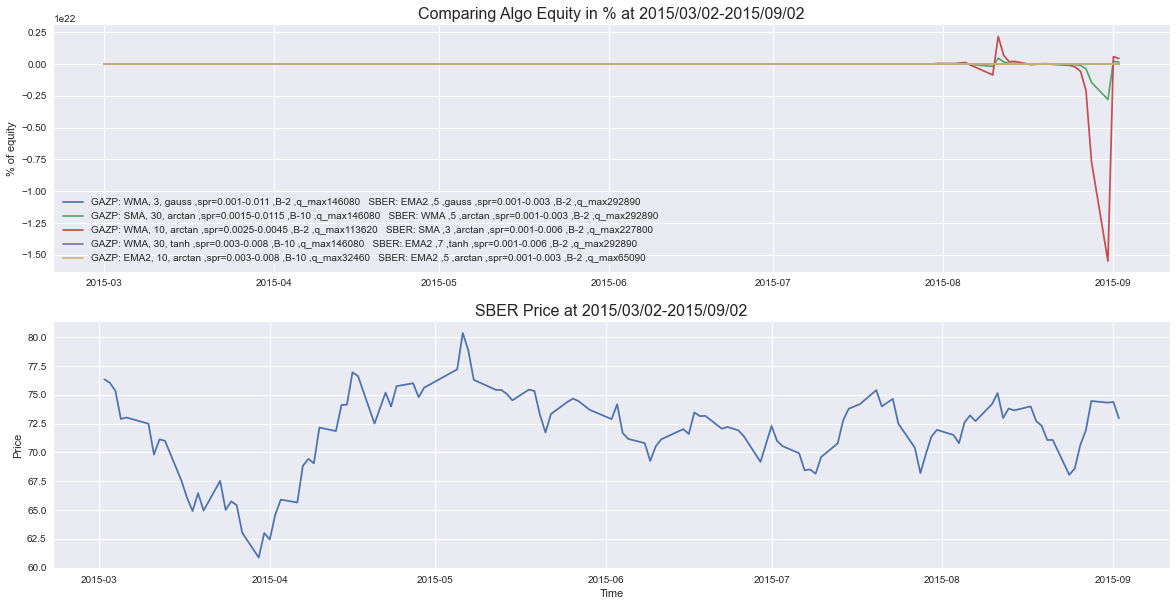

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
"GAZP: WMA, 3, gauss ,spr=0.001-0.011 ,B-2 ,q_max146080 SBER: EMA2 ,5 ,gauss ,spr=0.001-0.003 ,B-2 ,q_max292890",184,10000000,1069373065126,951378495,1036928341,10369.28%,-4.43%,2.56%,0.09,0.49,0.00,-4.25%,-3.970081214485456e+18%,976524351581496410112,42320226471600906567680,10369.28
"GAZP: SMA, 30, arctan ,spr=0.0015-0.0115 ,B-10 ,q_max146080 SBER: WMA ,5 ,arctan ,spr=0.001-0.003 ,B-2 ,q_max292890",184,10000000,1120008222776,937555033,1027155691,10271.56%,-4.43%,2.55%,0.09,0.45,0.00,-4.52%,-7.619892653274485e+21%,15641409017421917226795008,45482226861483164826599424,10271.56
"GAZP: WMA, 10, arctan ,spr=0.0025-0.0045 ,B-2 ,q_max113620 SBER: SMA ,3 ,arctan ,spr=0.001-0.006 ,B-2 ,q_max227800",184,10000000,1089703834985,822153533,909329840,9093.3%,-4.43%,2.49%,0.09,0.39,0.00,-4.4%,-5.1067711815341906e+22%,43931221908180428954533888,216980916244011063508467712,9093.30
"GAZP: WMA, 30, tanh ,spr=0.003-0.008 ,B-10 ,q_max146080 SBER: EMA2 ,7 ,tanh ,spr=0.001-0.006 ,B-2 ,q_max292890",184,10000000,982402826121,598175054,676767280,6767.67%,-4.43%,2.33%,0.09,0.33,0.00,-4.23%,-2.2760183109322477e+17%,-47195926285203406848,645692209140627931136,6767.67
"GAZP: EMA2, 10, arctan ,spr=0.003-0.008 ,B-10 ,q_max32460 SBER: EMA2 ,5 ,arctan ,spr=0.001-0.003 ,B-2 ,q_max65090",184,10000000,751593103497,595089382,655216831,6552.17%,-4.43%,2.31%,0.09,0.45,0.00,-3.27%,-346100311.52%,270,4019514090,6552.17
"GAZP: WMA, 7, tanh ,spr=0.0025-0.0125 ,B-10 ,q_max146080 SBER: WMA ,10 ,tanh ,spr=0.001-0.003 ,B-2 ,q_max292890",184,10000000,923694048644,540713567,614609091,6146.09%,-4.43%,2.27%,0.09,0.32,0.00,-4.09%,-27525231780199.66%,18526854994335684,173523303338407488,6146.09
"GAZP: SMA, 20, tanh ,spr=0.0015-0.0065 ,B-2 ,q_max32460 SBER: WMA ,3 ,tanh ,spr=0.001-0.006 ,B-2 ,q_max65090",184,10000000,749002011660,506870999,566791160,5667.91%,-4.43%,2.23%,0.09,0.37,0.00,-3.72%,-368019784.04%,659788,1239565112316,5667.91
"GAZP: WMA, 7, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max146080 SBER: WMA ,50 ,tanh ,spr=0.001-0.003 ,B-2 ,q_max292890",184,10000000,576524289785,483883577,530005520,5300.06%,-4.43%,2.19%,0.09,0.53,0.01,-3.48%,-678508.67%,-563,30768999,5300.06
"GAZP: SMA, 10, tanh ,spr=0.003-0.005 ,B-2 ,q_max113620 SBER: EMA2 ,50 ,tanh ,spr=0.001-0.006 ,B-2 ,q_max227800",184,10000000,486765132120,431406232,470347443,4703.47%,-4.43%,2.13%,0.09,0.60,0.01,-3.51%,-801524.57%,-883,10000000,4703.47
"GAZP: WMA, 5, arctan ,spr=0.003-0.013 ,B-2 ,q_max146080 SBER: EMA2 ,20 ,arctan ,spr=0.001-0.003 ,B-2 ,q_max292890",184,10000000,757096349384,397958328,458526036,4585.26%,-4.43%,2.11%,0.09,0.29,0.00,-4.05%,-507215319.46%,9183201,835329711638,4585.26


None


<Figure size 576x396 with 0 Axes>

In [69]:
hard_res_compare(overall_res,
                 models,
                 shares=share_corr) 

In [ ]:
import json

path = "optimizations/hard_res/LKOH TATNcash500000/WMAWMAtanh10-5/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv"
share_lst = pd.read_csv(path).columns[1:]
res_corr = []

for share in share_lst:
    tmp = list(pd.read_csv(path)[share])
    res_share = []
    for day_st in tmp:
        res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
    res_corr.append(pd.DataFrame(res_share).set_index("Date"))

multystock_stat(res_corr, Hard_Correlation_MM(hyperparams, corr_matrix), list(share_lst))

# Достанем подробные результаты по конкретным комбинациям

In [602]:
lk_path_lst = [
    "optimizations/hard_res/LKOH TATNcash500000/WMAEMAgauss5-15/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/WMAEMAtanh5-15/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.014B-2,q_max3637,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/WMAEMAtanh5-15/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/WMAEMAgauss5-15/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.014B-2,q_max3637,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/WMAEMAarctan5-15/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.014B-2,q_max3637,basvol - 323.csv"
]
lk_name_lst = [
    "LKOH: WMA, 5, gauss ,spr=0.0025-0.0045 ,B-2 ,q_max374 TATN: EMA ,15 ,gauss ,spr=0.004-0.006 ,B-2 ,q_max3469",
    "LKOH: WMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max374 TATN: EMA ,15 ,tanh ,spr=0.004-0.014 ,B-2 ,q_max3469",
    "LKOH: WMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max374 TATN: EMA ,15 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469",
    "LKOH: WMA, 5, gauss ,spr=0.0025-0.0045 ,B-2 ,q_max374 TATN: EMA ,15 ,gauss ,spr=0.004-0.014 ,B-2 ,q_max3469",
    "LKOH: WMA, 5, arctan ,spr=0.0025-0.0045 ,B-2 ,q_max374 TATN: EMA ,15 ,arctan ,spr=0.004-0.014 ,B-2 ,q_max3469"
    
]

In [672]:
path_lst = [
    "optimizations/hard_res/LKOH TATNcash500000/WMAWMAtanh10-5/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/EMASMAtanh5/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.014B-2,q_max3637,basvol - 323.csv",  
    "optimizations/hard_res/LKOH TATNcash500000/EMAWMAarctan15/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max36141TATN,spr=0.004-0.006B-2,q_max2829,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/EMAWMAarctan15/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv",
    "optimizations/hard_res/LKOH TATNcash500000/EMAWMAgauss15/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv"#,
    #"optimizations/hard_res/LKOH TATNcash500000/EMASMAgauss15-10/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max46441TATN,spr=0.004-0.014B-2,q_max3637,basvol - 323.csv",
    #"optimizations/hard_res/LKOH TATNcash500000/EMAWMAtanh15/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv"
]



name_lst = [
    "LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469",
    "LKOH: EMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: SMA ,5 ,tanh ,spr=0.004-0.014 ,B-2 ,q_max3637",
    "LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max291 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max2698",
    "LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max3469",
    "LKOH: EMA, 15, gauss ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,gauss ,spr=0.004-0.006 ,B-2 ,q_max3469",
    #"LKOH: EMA, 15, gauss ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: SMA ,10 ,gauss ,spr=0.004-0.014 ,B-2 ,q_max3469",
    #"LKOH: EMA, 15, tanh ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469"
]

In [679]:
path_lst = [
    "optimizations/hard_res/LKOH TATNcash500000/WMAWMAtanh10-5/y-20150301-20150902LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max37433TATN,spr=0.004-0.006B-2,q_max3469,basvol - 308.csv",
    "optimizations/hard_res/LKOH TATNcash500000/EMASMAtanh5/y-20150301-20150902LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max37433TATN,spr=0.004-0.014B-2,q_max3469,basvol - 308.csv",  
    "optimizations/hard_res/LKOH TATNcash500000/EMAWMAarctan15/y-20150301-20150902LKOH,spr=0.004-0.006,B-2,q_max29133TATN,spr=0.004-0.006B-2,q_max2698,basvol - 308.csv",
    "optimizations/hard_res/LKOH TATNcash500000/EMAWMAarctan15/y-20150301-20150902LKOH,spr=0.004-0.006,B-2,q_max37433TATN,spr=0.004-0.006B-2,q_max3469,basvol - 308.csv",
    "optimizations/hard_res/LKOH TATNcash500000/EMAWMAgauss15/y-20150301-20150902LKOH,spr=0.004-0.006,B-2,q_max37433TATN,spr=0.004-0.006B-2,q_max3469,basvol - 308.csv"#,
    #"optimizations/hard_res/LKOH TATNcash500000/EMASMAgauss15-10/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max46441TATN,spr=0.004-0.014B-2,q_max3637,basvol - 323.csv",
    #"optimizations/hard_res/LKOH TATNcash500000/EMAWMAtanh15/y-20150901-20160302LKOH,spr=0.004-0.006,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv"
]
name_lst = [
    "LKOH: EMA, 15, gauss ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,gauss ,spr=0.004-0.006 ,B-2 ,q_max3469",
    "LKOH: EMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: SMA ,5 ,tanh ,spr=0.004-0.014 ,B-2 ,q_max3637",
    "LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max291 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max2698",
    "LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max3469",
    "LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469"
    
]
#name_lst = path_lst



In [680]:
overall_res = [None] * len(share_corr)
models = []
for i in range(len(path_lst)):
    path = path_lst[i]
    name = name_lst[i]
    try:
        file = pd.read_csv(path)
        num += 1
    except Exception as e:
        print(e, i, name)
        try:
            file = pd.read_csv(alter_path)
            path = alter_path
            alter_num += 1
        except Exception as e:
            print(e, i, name)
            continue

    try:
        for share in range(len(share_corr)):
            tmp = list(file[share_corr[share]])
            res_share = []
            for day_st in tmp:
                res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
            if overall_res[share]:
                overall_res[share].append(pd.DataFrame(res_share).set_index("Date").drop_duplicates())
            else:
                overall_res[share] = [pd.DataFrame(res_share).set_index("Date")]
    except Exception as e:
        if str(e) != "'LKOH'":
            out = e

            print("find strange path ", path, "\n exception - ", e)
        continue

    models.append(Hard_Correlation_MM(hyperparams, corr_matrix, name=name, cash=500000))


Stats for date - 20150302 - 20150902


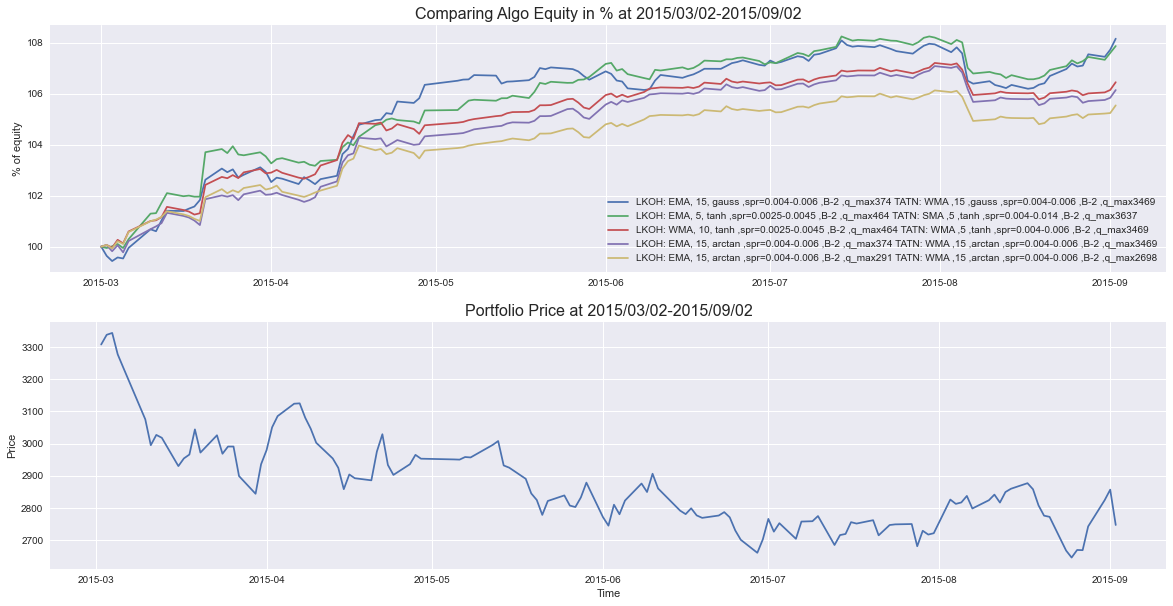

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
"LKOH: EMA, 15, gauss ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,gauss ,spr=0.004-0.006 ,B-2 ,q_max3469",184,1000000,165894328,65532,78803,7.88%,-16.95%,0.04%,0.26,0.48,4.49,-1.26%,-1.75%,1081585,1081585,7.88
"LKOH: EMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: SMA ,5 ,tanh ,spr=0.004-0.014 ,B-2 ,q_max3637",184,1000000,245466877,56527,76164,7.62%,-16.95%,0.04%,0.24,0.54,4.91,-1.38%,-1.55%,1078696,1082464,7.62
"LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469",184,1000000,107738207,54145,62764,6.28%,-16.95%,0.03%,0.25,0.54,4.71,-0.72%,-1.33%,1064505,1072063,6.28
"LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max3469",184,1000000,106573357,51360,59886,5.99%,-16.95%,0.03%,0.24,0.46,4.18,-0.82%,-1.43%,1061433,1070832,5.99
"LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max291 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max2698",184,1000000,108927655,45433,54147,5.41%,-16.95%,0.03%,0.24,0.47,4.33,-0.62%,-1.25%,1055411,1061296,5.41


None
Stats for date - 20150302 - 20150902


<Figure size 576x396 with 0 Axes>

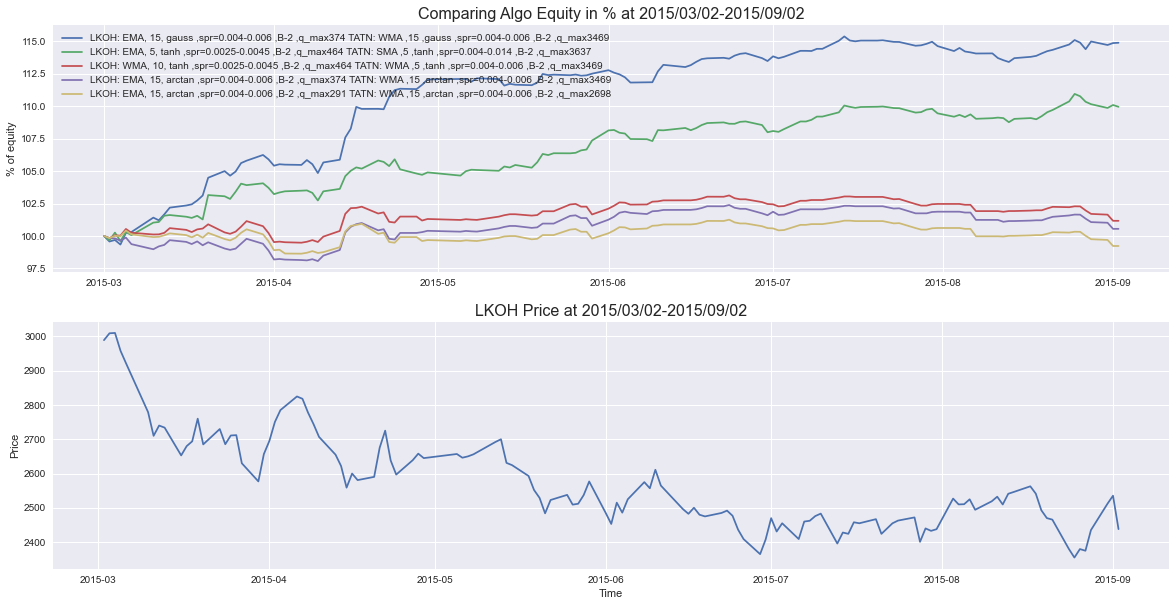

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
"LKOH: EMA, 15, gauss ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,gauss ,spr=0.004-0.006 ,B-2 ,q_max3469",184,500000,113098592,60796,69844,13.97%,-18.43%,0.07%,0.3,0.74,8.19,-0.77%,-1.71%,574427,576868,13.97
"LKOH: EMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: SMA ,5 ,tanh ,spr=0.004-0.014 ,B-2 ,q_max3637",184,500000,198994952,31922,47842,9.57%,-18.43%,0.05%,0.21,0.45,7.51,-0.89%,-1.27%,549758,554720,9.57
"LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469",184,500000,60487423,1174,6013,1.2%,-18.43%,0.01%,0.04,0.06,0.63,-0.81%,-1.9%,505839,515620,1.20
"LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max3469",184,500000,59730086,-1819,2959,0.59%,-18.43%,0.0%,0.02,0.03,0.31,-0.82%,-1.93%,502744,511932,0.59
"LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max291 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max2698",184,500000,61464923,-8595,-3678,-0.74%,-18.43%,-0.0%,-0.02,-0.03,-0.37,-0.98%,-2.0%,496140,506283,-0.74


None
Stats for date - 20150302 - 20150902


<Figure size 576x396 with 0 Axes>

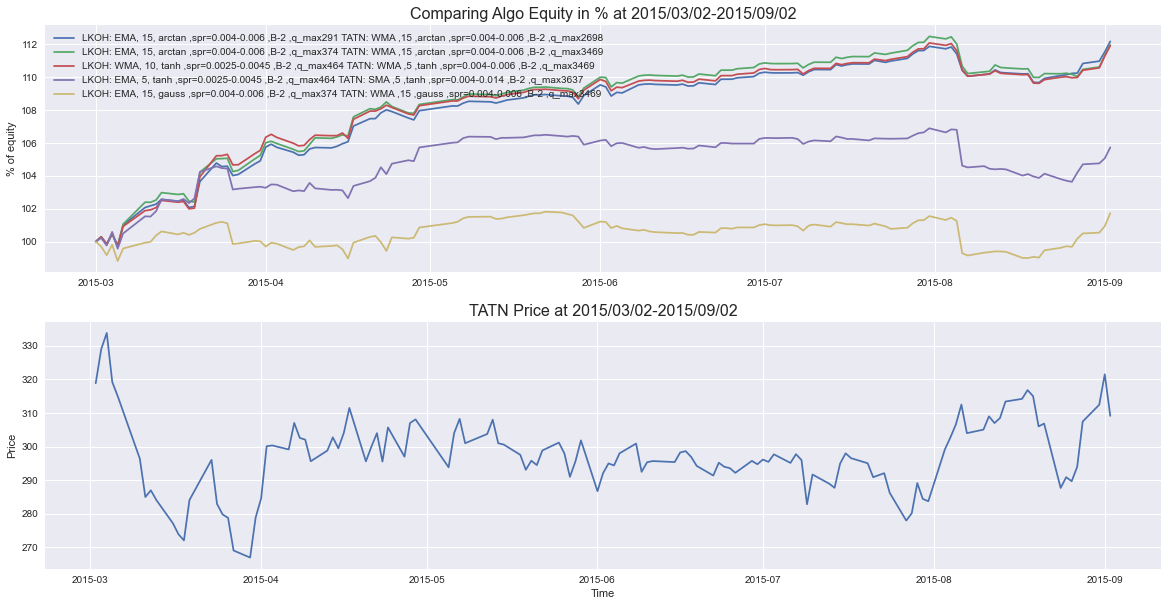

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
"LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max291 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max2698",184,500000,47462732,54028,57825,11.57%,-3.04%,0.06%,0.28,0.57,5.88,-1.25%,-1.97%,560884,560884,11.57
"LKOH: EMA, 15, arctan ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,arctan ,spr=0.004-0.006 ,B-2 ,q_max3469",184,500000,46843271,53180,56927,11.39%,-3.04%,0.06%,0.24,0.48,5.13,-1.65%,-2.22%,559780,562403,11.39
"LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469",184,500000,47250784,52971,56751,11.35%,-3.04%,0.06%,0.25,0.51,5.18,-1.44%,-2.19%,559607,560430,11.35
"LKOH: EMA, 5, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: SMA ,5 ,tanh ,spr=0.004-0.014 ,B-2 ,q_max3637",184,500000,46471924,24605,28322,5.66%,-3.04%,0.03%,0.12,0.17,1.86,-2.56%,-3.05%,528647,534471,5.66
"LKOH: EMA, 15, gauss ,spr=0.004-0.006 ,B-2 ,q_max374 TATN: WMA ,15 ,gauss ,spr=0.004-0.006 ,B-2 ,q_max3469",184,500000,52795735,4736,8959,1.79%,-3.04%,0.01%,0.04,0.05,0.65,-2.43%,-2.77%,508655,509106,1.79


None


<Figure size 576x396 with 0 Axes>

In [681]:
hard_res_compare(overall_res,
                 models,
                 shares=share_corr)

# Теперь сравним по акциям

In [711]:
file = pd.read_csv("optimizations/hard_res/LKOH TATNcash500000/WMAWMAtanh10-5/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv")
name = "Hard"#"LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469"

tmp = list(file["TATN"])
res_share = []
for day_st in tmp:
    res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
hard_res = pd.DataFrame(res_share).set_index("Date").drop_duplicates()
hard_model = Hard_Correlation_MM(hyperparams, corr_matrix, name=name, cash=500000)


In [712]:
basic_res = pd.read_csv("optimizations/basic_res/TATN/year20150901-20160302 spread - 0.013 sma tick len - 30.csv").set_index("Date")
basic_model = Basic_MM(name="Basic", cash=500000)

In [713]:
boll_res = pd.read_csv("optimizations/boll_res/TATN/year20150901-20160302 spread - 0.009 sma tick len - 50std -2.5.csv").set_index("Date")
boll_model = Basic_MM(name="Bollinger", cash=500000)

Stats for date - 20150902 - 20160229


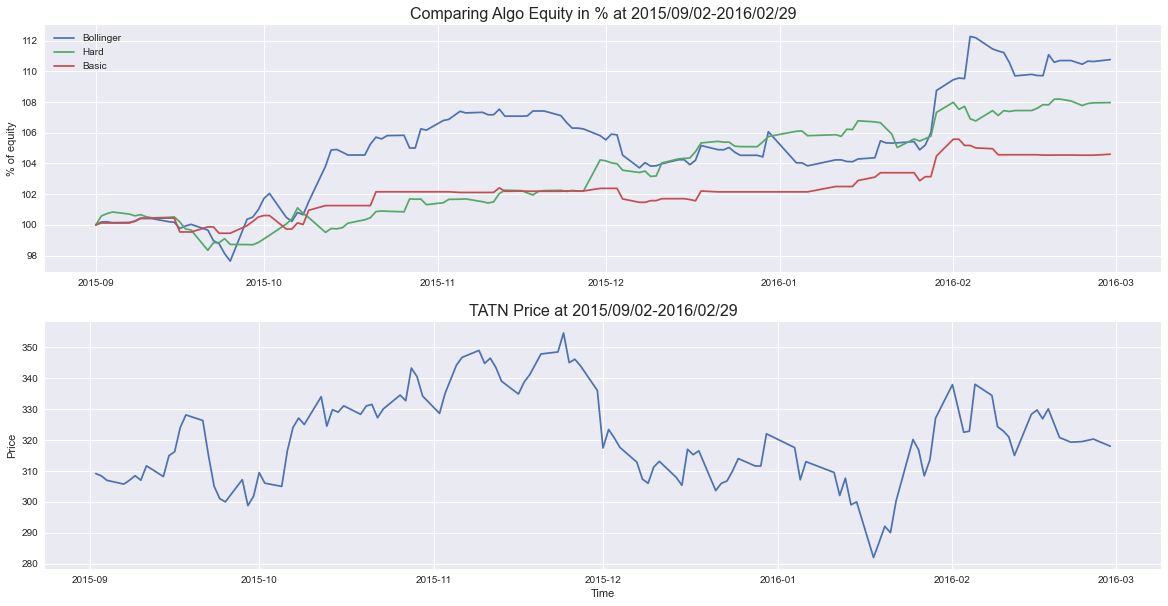

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
Bollinger,180,500000,34605117,49675,52444,10.49%,2.86%,0.06%,0.13,0.25,2.95,-2.28%,-3.55%,553827,561375,10.49
Hard,180,500000,61917730,33845,38799,7.76%,2.86%,0.04%,0.16,0.28,3.14,-1.51%,-2.47%,539829,540981,7.76
Basic,180,500000,6555761,22204,22729,4.55%,2.86%,0.02%,0.14,0.24,4.62,-1.34%,-1.34%,523014,527899,4.55


<Figure size 576x396 with 0 Axes>

In [714]:
compare_algo([hard_res, boll_res, basic_res],
            [hard_model, boll_model, basic_model],
            share="TATN")

In [715]:
file = pd.read_csv("optimizations/hard_res/LKOH TATNcash500000/WMAEMAgauss5-15/y-20150901-20160302LKOH,spr=0.0025-0.0045000000000000005,B-2,q_max46441TATN,spr=0.004-0.006B-2,q_max3637,basvol - 323.csv")
name = "Hard"#"LKOH: WMA, 10, tanh ,spr=0.0025-0.0045 ,B-2 ,q_max464 TATN: WMA ,5 ,tanh ,spr=0.004-0.006 ,B-2 ,q_max3469"

tmp = list(file["LKOH"])
res_share = []
for day_st in tmp:
    res_share.append(dict(json.loads(day_st.replace('\'', '\"'))))
hard_res = pd.DataFrame(res_share).set_index("Date").drop_duplicates()
hard_model = Hard_Correlation_MM(hyperparams, corr_matrix, name=name, cash=500000)

In [716]:
basic_res = pd.read_csv("optimizations/basic_res/LKOH/year20150901-20160302 spread - 0.003 sma tick len - 5.csv").set_index("Date")
basic_model = Basic_MM(name="Basic", cash=500000)

In [717]:
boll_res = pd.read_csv("optimizations/boll_res/LKOH/year20150901-20160302 spread - 0.002 sma tick len - 25std -2.5.csv").set_index("Date")
boll_model = Basic_MM(name="Bollinger", cash=500000)

Stats for date - 20150902 - 20160229


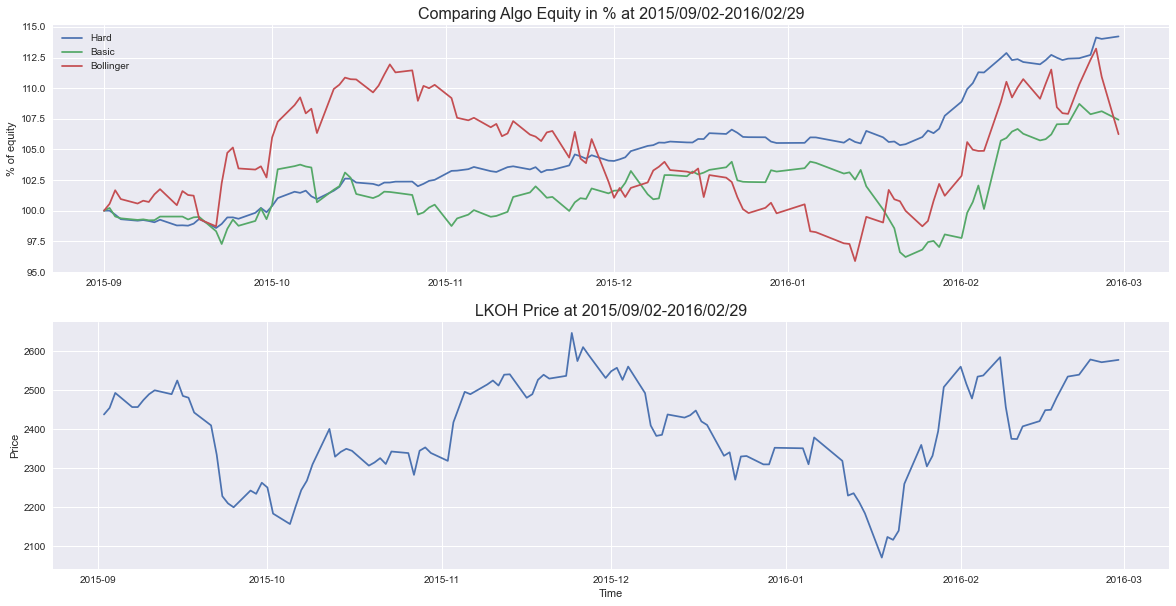

,Duration,Initial cash,Algo Turnover,P&L Net,P&L Gross,Total algo return gross,Buy & Hold Return,Geometric mean Day Return,Sharp ratio,Sortino ratio,Calmar ratio,Max Drawdown at day,Peak to Valley Drawdown,Equity final,Equity peak,float return
Hard,180,500000,246542656,47215,66938,13.39%,5.74%,0.07%,0.29,0.62,9.45,-1.46%,-1.46%,571104,571104,13.39
Basic,180,500000,202372496,22427,38617,7.72%,5.74%,0.04%,0.07,0.11,1.03,-3.82%,-7.48%,537098,543581,7.72
Bollinger,180,500000,1580316276,-90502,35924,7.18%,5.74%,0.04%,0.04,0.06,0.5,-5.13%,-14.34%,531215,566130,7.18


<Figure size 576x396 with 0 Axes>

In [718]:
compare_algo([hard_res, boll_res, basic_res],
            [hard_model, boll_model, basic_model],
            share="LKOH")